# Problem Definition

Use historical boxscores to predict an NBA player's Ownership Percentage, or the percent of lineups in a contest that include the player. I will only project a player's ownerhship percentage for GPP contests.

### Usage

This projection will help evaluate players when building lineups to enter DFS contests.

# Setup

Import the necessary libraries

In [1]:
# for data
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from pyNBA.Data.data import QueryData
from pyNBA.Models.helpers import CleanData
import math
from pyNBA.Data.constants import BAD_CONTEST_SUBSTRINGS, DB_TEAM_TO_NBA_TEAM, OWNERSHIP_NAME_TO_NBA_NAME
from functools import reduce

# for features
from pyNBA.Models.features import FeatureCreation
from pyNBA.Models.cluster import Cluster, Evaluate
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE
from pyNBA.DFS.rules import FPCalculator
from pyNBA.DFS.constants import Site

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns
from research import Helpers
from statsmodels.graphics.api import abline_plot

# for statistical tests
from scipy.stats import shapiro
import pingouin as pg

# for machine learning
from sklearn import model_selection, preprocessing, ensemble, neighbors, linear_model, svm, neural_network, metrics
import xgboost as xgb
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# for explainer
from lime import lime_tabular

# misc
import warnings
warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

/Users/brandonshimiaie/Projects/pyNBA/venv/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.3, the latest is 0.3.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


# Factor Determination
Determine the factors that influence a player's Ownership Percentage.

- Player Data
    - Fantasy production
    - Value
    - Recent value
    - Salary
    - Salary change
    - Starter
    - Variance
    - Positions
    - Number of positions
    - Average Ownership
    - Recent Ownership
    - Number of positions of player
    - Positions of player (binary)


- Defense
    - DvP
    - Vegas total
    - Vegas point spread


- Contest Info
    - Number of entries in contest
    - Max entries per person
    - Entry fee
    - Top prize
    

- Slate
    - Number of games in slate
    - Number of players in position
    - Player position value rank
    - Number of players close to salary in position

# Data
Pull all necessary data, and prepare it for regression.

First, I will pull all necessary historical data.

In [2]:
query_data = QueryData()
clean_data = CleanData()

# pull boxscore data
boxscores = query_data.query_boxscore_data()

# we are only interested in the boxscores of healthy and non-resting players
boxscores = clean_data.drop_rows_player_injured(boxscores)
boxscores = clean_data.drop_rows_player_rest(boxscores)

# historical DFS salary data
salary_data = query_data.query_salary_data()
salary_data = salary_data.rename(columns={"POSITION": "DFS_POSITION"})

# historical DFS contest data. I am only interested in predicting ownership in Classic GPP compeititions.
contest_data = query_data.query_contest_data()
contest_data = contest_data.loc[
    (contest_data['CASHLINE'] > 0) & (contest_data['SLATETYPE'] == 'Classic') & (contest_data['CASHLINE'] > 200) &
    (~contest_data['CONTESTNAME'].str.lower().str.contains('|'.join(BAD_CONTEST_SUBSTRINGS)))
].dropna(subset=['CASHLINE'])
contest_data['MAXROI'] = contest_data['TOPPRIZE']/contest_data['ENTRYFEE']
contest_data = contest_data.loc[contest_data['MAXROI'] > 2]

# historical player ownership
ownership_data = query_data.query_ownership_data()

# historical vegas odds data
odds_data = query_data.query_odds_data()

/Users/brandonshimiaie/Projects/pyNBA/sqlite/db/nba.db
2.6.0


Method to standardize a player's name, to join the salaries and boxscores tables.

In [4]:
salary_data['NAME'] = salary_data['PLAYER'].apply(clean_data.roto_name_to_nba_name)
salary_data = salary_data.loc[salary_data['SITE'] == Site.DRAFTKINGS]
boxscores = boxscores.merge(salary_data, how='left', on=['DATE', 'NAME'])

# Feature Engineering
Create new features from raw data using domain knowlege.

In [5]:
y = 'OWNERSHIP'
regressors = []
categorical_regressors = []

### Player Production
First, I will create features that represent a player's production.

In [6]:
DKFPCalculator = FPCalculator(Site.DRAFTKINGS)

boxscores['REB'] = boxscores['DREB'] + boxscores['OREB']
boxscores['DKFP'] = boxscores.apply(
    lambda x: DKFPCalculator.calculate_fantasy_points(
        x['SEASON'], x['PTS'], x['REB'], x['AST'], x['TOV'], x['BLK'], x['STL'], x['FG3M']
    ), 
    axis=1
)

feature_creation = FeatureCreation()

boxscores = feature_creation.expanding_mean(
    df=boxscores, group_col_names=['SEASON', 'PLAYERID'], col_name='DKFP', new_col_name='AVG_DKFP'
)
regressors.append('AVG_DKFP')

boxscores['VALUE'] = boxscores['AVG_DKFP']/boxscores['SALARY']
regressors.append('VALUE')

boxscores = feature_creation.lag(
    df=boxscores, group_col_names=['SEASON', 'PLAYERID'], col_name='DKFP', new_col_name='L1_DKFP', n_shift=1
)
regressors.append('L1_DKFP')

boxscores = feature_creation.rolling_mean(
    df=boxscores, group_col_names=['SEASON', 'PLAYERID'], col_name='DKFP', new_col_name='MA5_DKFP', n_rolling=5
)
regressors.append('MA5_DKFP')

boxscores = feature_creation.lag(
    df=boxscores, group_col_names=['SEASON', 'PLAYERID'], col_name='SALARY', new_col_name='L1_SALARY', n_shift=1
)
boxscores['SALARY_CHANGE'] = boxscores['SALARY'] - boxscores['L1_SALARY']
regressors.append('SALARY')
regressors.append('SALARY_CHANGE')

boxscores = feature_creation.expanding_standard_deviation(
    df=boxscores, group_col_names=['SEASON', 'PLAYERID'], col_name='DKFP', new_col_name='STD_DKFP', min_periods=5
)
boxscores['STD_DKFP'] = boxscores['STD_DKFP'].fillna(0.25*boxscores['AVG_DKFP'])
regressors.append('STD_DKFP')

regressors.append('START')

boxscores['DFS_POSITIONS'] = boxscores['DFS_POSITION'].apply(lambda x: x.split('_') if isinstance(x, str) else np.nan)
boxscores['NUM_POSITIONS'] = boxscores['DFS_POSITIONS'].apply(lambda x: len(x) if isinstance(x, list) else np.nan)
regressors.append('NUM_POSITIONS')

In [28]:
for position in list(boxscores['DFS_POSITIONS'].dropna().explode().unique()):
    boxscores[position] = 0
    boxscores.loc[boxscores['DFS_POSITION'].str.contains(position), position] = 1
    regressors.append(position)
    categorical_regressors.append(position)

In [8]:
ownership_data['NAME'] = ownership_data['PLAYERNAME'].apply(lambda x: x if x not in OWNERSHIP_NAME_TO_NBA_NAME else OWNERSHIP_NAME_TO_NBA_NAME[x])
ownership_data = ownership_data.merge(contest_data, on=['SLATEID', 'CONTESTNAME'], how='left')
aggregated_ownership = ownership_data.groupby(['DATE', 'NAME']).apply(
    lambda x: pd.Series({
        'TOTAL_OWNERSHIP': x['OWNERSHIP'].mean()
    })
).reset_index()

data = data.merge(aggregated_ownership, on=['DATE', 'NAME'], how='left')

data = feature_creation.expanding_mean(
    df=data, group_col_names=['SEASON', 'NAME'], col_name='OWNERSHIP', new_col_name='AVG_OWNERSHIP'
)
self.regressors.append('AVG_OWNERSHIP')

data = feature_creation.lag(
    df=data, group_col_names=['SEASON', 'NAME'], col_name='OWNERSHIP', new_col_name='L1_OWNERSHIP', n_shift=1
)
self.regressors.append('L1_OWNERSHIP')

data = feature_creation.rolling_mean(
    df=data, group_col_names=['SEASON', 'NAME'], col_name='OWNERSHIP', new_col_name='MA5_OWNERSHIP', n_rolling=5
)
self.regressors.append('MA5_OWNERSHIP')

### Defense
I will create features that describe how favorable a matchup is, from a fantasy point production standpoint.

DvP

In [9]:
boxscores['NORM_POS'] = boxscores['POSITION'].apply(lambda x: x if '-' not in x else x.split('-')[0])

temp = boxscores.dropna(subset=['DKFP', 'AVG_DKFP'])
grouped_defensive_boxscores = temp.groupby(['SEASON', 'DATE', 'NORM_POS', 'OPP_TEAM']).apply(
    lambda x: pd.Series({
        'TEAM_DKFP_ALLOWED_P': x['DKFP'].sum(),
        'TEAM_DKFP_AVG_P': x['AVG_DKFP'].sum()
    })
).reset_index()

grouped_defensive_boxscores['DvP'] = grouped_defensive_boxscores['TEAM_DKFP_ALLOWED_P'] - grouped_defensive_boxscores['TEAM_DKFP_AVG_P']

grouped_defensive_boxscores = feature_creation.expanding_mean(
    df=grouped_defensive_boxscores, group_col_names=['SEASON', 'OPP_TEAM', 'NORM_POS'], col_name='DvP',
    new_col_name='AVG_DvP', order_idx_name='DATE', min_periods=5
)
regressors.append('AVG_DvP')

boxscores = boxscores.merge(grouped_defensive_boxscores, on=['SEASON', 'DATE', 'OPP_TEAM', 'NORM_POS'], how='left')

Vegas Lines

In [10]:
odds_data['TOTAL'] = odds_data['TOTAL'].replace(['PK', '-'], np.nan)
odds_data['POINTSPREAD'] = odds_data['POINTSPREAD'].replace(['PK', '-'], 0)
full_game_odds = odds_data.loc[odds_data['PERIOD'] == 'Full Game']
boxscores = boxscores.merge(full_game_odds, on=['DATE', 'TEAM'], how='left')
regressors.append('TOTAL')
regressors.append('POINTSPREAD')

### Contest Info
I will also include features that describe the contest.

In [11]:
regressors.append('TOTALENTRIES')
regressors.append('MAXENTRIES')
regressors.append('ENTRYFEE')
regressors.append('TOPPRIZE')
regressors.append('GAMECOUNT')

### Slate Info
Lastly, I will include features that capture the slate's depth of each position, salary range, and how each player's expeted value compares to other players in the same position/salary range.

In [13]:
slates = contest_data.loc[contest_data['SITE'] == self.site, ['DATE', 'SLATEID', 'TEAMS']].drop_duplicates()
slates['TEAMS'] = slates['TEAMS'].apply(lambda x: x.split('_'))
slates = slates.explode('TEAMS').rename(columns={"TEAMS": "TEAM"})
slates['TEAM'] = slates['TEAM'].apply(lambda x: x if x not in DB_TEAM_TO_NBA_TEAM else DB_TEAM_TO_NBA_TEAM[x])

slate_players = boxscores[['DATE', 'TEAM', 'NAME', 'DFS_POSITIONS', 'SALARY', 'VALUE']].merge(
    slates, on=['DATE', 'TEAM'], how='left'
    )
slate_players['SALARY_BIN'] = pd.cut(
    slate_players['SALARY'], bins=list(range(3000, 15000, 1000)), duplicates='drop', include_lowest=True
    )
slate_players = slate_players.explode('DFS_POSITIONS').rename(columns={'DFS_POSITIONS': 'SINGLE_DFS_POSITION'})

In [15]:
MIN_VALUE = 0.002

all_temp = slate_players.groupby(['SLATEID', 'SINGLE_DFS_POSITION']).apply(
    lambda x: pd.Series({
        'L1P_COUNT': x.loc[x['VALUE'] > MIN_VALUE, 'NAME'].count()
    })
).reset_index().dropna()
slate_players = slate_players.merge(all_temp, on=['SLATEID', 'SINGLE_DFS_POSITION'], how='left')

sb_temp = slate_players.groupby(['SLATEID', 'SINGLE_DFS_POSITION', 'SALARY_BIN']).apply(
    lambda x: pd.Series({
        'L1P_SB_COUNT': x['NAME'].count()
    })
).reset_index().dropna()
slate_players = slate_players.merge(sb_temp, on=['SLATEID', 'SINGLE_DFS_POSITION', 'SALARY_BIN'], how='left')

In [16]:
L1_TO_L2 = {'PG': 'G', 'SG': 'G', 'SF': 'F', 'PF': 'F', 'C': 'C'}
slate_players['LEVEL2_DFS_POSITION'] = slate_players['SINGLE_DFS_POSITION'].apply(lambda x: L1_TO_L2[x] if isinstance(x, str) else np.nan)

all_temp = slate_players.groupby(['SLATEID', 'LEVEL2_DFS_POSITION']).apply(
    lambda x: pd.Series({
        'L2P_COUNT': x.loc[x['VALUE'] > MIN_VALUE, 'NAME'].count()
    })
).reset_index().dropna()
slate_players = slate_players.merge(all_temp, on=['SLATEID', 'LEVEL2_DFS_POSITION'], how='left')

sb_temp = slate_players.groupby(['SLATEID', 'LEVEL2_DFS_POSITION', 'SALARY_BIN']).apply(
    lambda x: pd.Series({
        'L2P_SB_COUNT': x['NAME'].count()
    })
).reset_index().dropna()
slate_players = slate_players.merge(sb_temp, on=['SLATEID', 'LEVEL2_DFS_POSITION', 'SALARY_BIN'], how='left')

In [17]:
all_temp = slate_players.groupby(['SLATEID']).apply(
    lambda x: pd.Series({
        'L3P_COUNT': x.loc[x['VALUE'] > MIN_VALUE, 'NAME'].count()
    })
).reset_index().dropna()
slate_players = slate_players.merge(all_temp, on=['SLATEID'], how='left')

sb_temp = slate_players.groupby(['SLATEID', 'SALARY_BIN']).apply(
    lambda x: pd.Series({
        'L3P_SB_COUNT': x.loc[x['VALUE'] > MIN_VALUE, 'NAME'].count()
    })
).reset_index().dropna()
slate_players = slate_players.merge(sb_temp, on=['SLATEID', 'SALARY_BIN'], how='left')

In [18]:
slate_players['SALARY_FLOOR'] = slate_players['SALARY_BIN'].apply(lambda x: x.left)

slate_players = slate_players.set_index(['SLATEID', 'SINGLE_DFS_POSITION'])
slate_players['L1P_RANK'] = slate_players['VALUE'].groupby(level=[0, 1]).rank(method='min', ascending=False)
slate_players = slate_players.reset_index(0).reset_index(0)

slate_players = slate_players.set_index(['SLATEID', 'SINGLE_DFS_POSITION', 'SALARY_FLOOR'])
slate_players['L1P_SB_RANK'] = slate_players['VALUE'].groupby(level=[0, 1, 2]).rank(method='min', ascending=False)
slate_players = slate_players.reset_index(0).reset_index(0).reset_index(0)

slate_players = slate_players.set_index(['SLATEID', 'LEVEL2_DFS_POSITION'])
slate_players['L2P_RANK'] = slate_players['VALUE'].groupby(level=[0, 1]).rank(method='min', ascending=False)
slate_players = slate_players.reset_index(0).reset_index(0)

slate_players = slate_players.set_index(['SLATEID', 'LEVEL2_DFS_POSITION', 'SALARY_FLOOR'])
slate_players['L2P_SB_RANK'] = slate_players['VALUE'].groupby(level=[0, 1, 2]).rank(method='min', ascending=False)
slate_players = slate_players.reset_index(0).reset_index(0).reset_index(0)

slate_players = slate_players.set_index(['SLATEID'])
slate_players['L3P_RANK'] = slate_players['VALUE'].groupby(level=[0]).rank(method='min', ascending=False)
slate_players = slate_players.reset_index(0)

slate_players = slate_players.set_index(['SLATEID', 'SALARY_FLOOR'])
slate_players['L3P_SB_RANK'] = slate_players['VALUE'].groupby(level=[0, 1]).rank(method='min', ascending=False)
slate_players = slate_players.reset_index(0).reset_index(0)

In [19]:
%%time

slate_data = slate_players.groupby(['DATE', 'SLATEID', 'NAME']).apply(
    lambda x: pd.Series({
        'L1P_COUNT': x['L1P_COUNT'].mean(),
        'L1P_RANK': x['L1P_RANK'].mean(),
        'L1P_SB_COUNT': x['L1P_SB_COUNT'].mean(),
        'L1P_SB_RANK': x['L1P_SB_RANK'].mean(),
        'L2P_COUNT': x['L2P_COUNT'].mean(),
        'L2P_RANK': x['L2P_RANK'].mean(),
        'L2P_SB_COUNT': x['L2P_SB_COUNT'].mean(),
        'L2P_SB_RANK': x['L2P_SB_RANK'].mean(),
        'L3P_COUNT': x['L3P_COUNT'].mean(),
        'L3P_RANK': x['L3P_RANK'].mean(),
        'L3P_SB_COUNT': x['L3P_SB_COUNT'].mean(),
        'L3P_SB_RANK': x['L3P_SB_RANK'].mean(),
    })
).reset_index()

CPU times: user 5min 41s, sys: 3.84 s, total: 5min 45s
Wall time: 5min 50s


In [20]:
regressors.append('L1P_COUNT')
regressors.append('L1P_RANK')
regressors.append('L1P_SB_COUNT')
regressors.append('L1P_SB_RANK')
regressors.append('L2P_COUNT')
regressors.append('L2P_RANK')
regressors.append('L2P_SB_COUNT')
regressors.append('L2P_SB_RANK')
regressors.append('L3P_COUNT')
regressors.append('L3P_RANK')
regressors.append('L3P_SB_COUNT')
regressors.append('L3P_SB_RANK')

In [21]:
boxscores['GP'] = 1
boxscores = feature_creation.expanding_sum(df=boxscores, group_col_names=['SEASON', 'PLAYERID'], col_name='GP', new_col_name='COUNT_GP')
regressors.append('COUNT_GP')

# Preprocessing
Now that I have created all the features I found to be indicative of our dependant variable, I will prepare the data to be suitable for a predictive model.

First, I will merge the player, contest, and slate features.

In [22]:
ownership_data = ownership_data.merge(slate_data, on=['DATE', 'SLATEID', 'NAME'], how='left')
all_ownership_data = ownership_data.merge(boxscores, on=['DATE', 'NAME'], how='left')

In [23]:
pd.set_option('display.max_columns', 200)
pd.set_option('display.min_rows', 100)
pd.set_option('display.max_rows', 100)
display(all_ownership_data[['DATE', 'NAME', 'SLATEID', 'CONTESTID'] + regressors + categorical_regressors + [y]].dropna(subset=[y]))

,DATE,NAME,SLATEID,CONTESTID,AVG_DKFP,VALUE,L1_DKFP,MA5_DKFP,SALARY,SALARY_CHANGE,STD_DKFP,START,NUM_POSITIONS,AVG_OWNERSHIP,L1_OWNERSHIP,MA5_OWNERSHIP,AVG_DvP,TOTAL,POINTSPREAD,TOTALENTRIES,MAXENTRIES,ENTRYFEE,TOPPRIZE,GAMECOUNT,L1P_COUNT,L1P_RANK,L1P_SB_COUNT,L1P_SB_RANK,L2P_COUNT,L2P_RANK,L2P_SB_COUNT,L2P_SB_RANK,L3P_COUNT,L3P_RANK,L3P_SB_COUNT,L3P_SB_RANK,COUNT_GP,SF,SG,PG,PF,C,OWNERSHIP
4,2017-10-18,Aaron Brooks,5ae4d5805689223dfa12d8ad,5ae60061fd67640e26e3794d,NaN,NaN,NaN,NaN,3000.0,NaN,NaN,0.0,2.0,NaN,NaN,NaN,NaN,205.5,1.0,1981,10.0,3.00,250.0,11,4.0,NaN,53.5,NaN,8.0,NaN,107.0,NaN,22.0,NaN,9.0,NaN,NaN,0.0,1.0,1.0,0.0,0.0,0.0005
10,2017-10-18,Aaron Brooks,5ae4d5805689223dfa12d8ad,5ae60694fd67640e26fde7cf,NaN,NaN,NaN,NaN,3000.0,NaN,NaN,0.0,2.0,NaN,NaN,NaN,NaN,205.5,1.0,11560,150.0,8.00,5000.0,11,4.0,NaN,53.5,NaN,8.0,NaN,107.0,NaN,22.0,NaN,9.0,NaN,NaN,0.0,1.0,1.0,0.0,0.0,0.0001
11,2017-10-18,Aaron Brooks,5ae4d5805689223dfa12d8ad,5ae6079e3825540e24ceb0bd,NaN,NaN,NaN,NaN,3000.0,NaN,NaN,0.0,2.0,NaN,NaN,NaN,NaN,205.5,1.0,5945,3.0,3.00,1000.0,11,4.0,NaN,53.5,NaN,8.0,NaN,107.0,NaN,22.0,NaN,9.0,NaN,NaN,0.0,1.0,1.0,0.0,0.0,0.0003
14,2017-10-18,Aaron Brooks,5ae4d5805689223dfa12d8ad,5ae624ad18875c209538a86e,NaN,NaN,NaN,NaN,3000.0,NaN,NaN,0.0,2.0,NaN,NaN,NaN,NaN,205.5,1.0,47562,20.0,1.00,2000.0,11,4.0,NaN,53.5,NaN,8.0,NaN,107.0,NaN,22.0,NaN,9.0,NaN,NaN,0.0,1.0,1.0,0.0,0.0,0.0001
15,2017-10-18,Aaron Brooks,5ae4d5805689223dfa12d8ad,5ae4dae5dd71203dfc6215ba,NaN,NaN,NaN,NaN,3000.0,NaN,NaN,0.0,2.0,NaN,NaN,NaN,NaN,205.5,1.0,14863,1.0,2.00,1500.0,11,4.0,NaN,53.5,NaN,8.0,NaN,107.0,NaN,22.0,NaN,9.0,NaN,NaN,0.0,1.0,1.0,0.0,0.0,0.0001
26,2017-10-18,Aaron Gordon,5ae4d5805689223dfa12d8ad,5ae4e27ac074cf3dff6ce595,NaN,NaN,NaN,NaN,6900.0,NaN,NaN,1.0,2.0,NaN,NaN,NaN,NaN,207.0,3.0,72,2.0,1500.00,25000.0,11,5.5,NaN,2.0,NaN,11.0,NaN,4.0,NaN,22.0,NaN,2.0,NaN,NaN,1.0,0.0,0.0,1.0,0.0,0.0139
27,2017-10-18,Aaron Gordon,5ae4d5805689223dfa12d8ad,5ae5f37a5641740e233b59b6,NaN,NaN,NaN,NaN,6900.0,NaN,NaN,1.0,2.0,NaN,NaN,NaN,NaN,207.0,3.0,1189,35.0,5.00,500.0,11,5.5,NaN,2.0,NaN,11.0,NaN,4.0,NaN,22.0,NaN,2.0,NaN,NaN,1.0,0.0,0.0,1.0,0.0,0.0387
29,2017-10-18,Aaron Gordon,5ae4d5805689223dfa12d8ad,5ae5fea9fd67640e26de689a,NaN,NaN,NaN,NaN,6900.0,NaN,NaN,1.0,2.0,NaN,NaN,NaN,NaN,207.0,3.0,296,3.0,150.00,6000.0,11,5.5,NaN,2.0,NaN,11.0,NaN,4.0,NaN,22.0,NaN,2.0,NaN,NaN,1.0,0.0,0.0,1.0,0.0,0.0405
30,2017-10-18,Aaron Gordon,5ae4d5805689223dfa12d8ad,5ae60061fd67640e26e3794d,NaN,NaN,NaN,NaN,6900.0,NaN,NaN,1.0,2.0,NaN,NaN,NaN,NaN,207.0,3.0,1981,10.0,3.00,250.0,11,5.5,NaN,2.0,NaN,11.0,NaN,4.0,NaN,22.0,NaN,2.0,NaN,NaN,1.0,0.0,0.0,1.0,0.0,0.0394
31,2017-10-18,Aaron Gordon,5ae4d5805689223dfa12d8ad,5ae601b3fd67640e26e79e79,NaN,NaN,NaN,NaN,6900.0,NaN,NaN,1.0,2.0,NaN,NaN,NaN,NaN,207.0,3.0,113,3.0,50.00,750.0,11,5.5,NaN,2.0,NaN,11.0,NaN,4.0,NaN,22.0,NaN,2.0,NaN,NaN,1.0,0.0,0.0,1.0,0.0,0.0177


The first thing I will do is handle missing data.

In [33]:
feature_matrix = all_ownership_data[['DATE', 'NAME'] + regressors + [y]]

In [34]:
feature_matrix['L1_DKFP'] = feature_matrix['L1_DKFP'].fillna(feature_matrix['AVG_DKFP'])
feature_matrix['MA5_DKFP'] = feature_matrix['MA5_DKFP'].fillna(feature_matrix['AVG_DKFP'])

feature_matrix['SALARY_CHANGE'] = feature_matrix['SALARY_CHANGE'].fillna(0)

feature_matrix['STD_DKFP'] = feature_matrix['STD_DKFP'].fillna(0.25*feature_matrix['AVG_DKFP'])

feature_matrix['L1_OWNERSHIP'] = feature_matrix['L1_OWNERSHIP'].fillna(feature_matrix['AVG_OWNERSHIP'])
feature_matrix['MA5_OWNERSHIP'] = feature_matrix['MA5_OWNERSHIP'].fillna(feature_matrix['AVG_OWNERSHIP'])

feature_matrix['AVG_DvP'] = feature_matrix['AVG_DvP'].fillna(0)

feature_matrix['TOTAL'] = feature_matrix['TOTAL'].fillna(feature_matrix['TOTAL'].mean())
feature_matrix['POINTSPREAD'] = feature_matrix['POINTSPREAD'].fillna(0)

feature_matrix['L1P_SB_COUNT'] = feature_matrix['L1P_SB_COUNT'].fillna(0)
feature_matrix['L2P_SB_COUNT'] = feature_matrix['L2P_SB_COUNT'].fillna(0)
feature_matrix['L3P_SB_COUNT'] = feature_matrix['L3P_SB_COUNT'].fillna(0)

# we can predict Y for a player as long as AVG_Y is not nan
feature_matrix = feature_matrix.dropna(subset=['AVG_OWNERSHIP'])

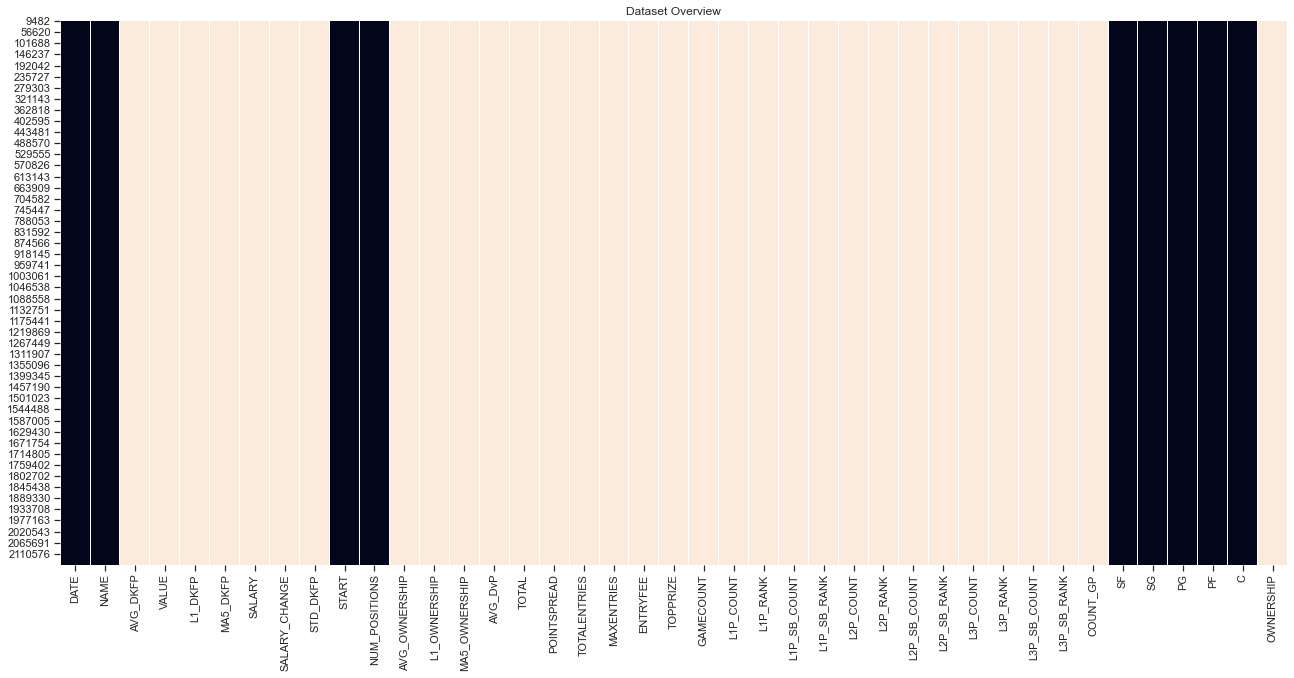

 Categerocial   Numeric   NaN 

Percentage of rows containing at least one missing value: 0.0


In [35]:
helpers = Helpers()
plt.rcParams["figure.figsize"] = (22, 10)
helpers.visualize_dataframe(feature_matrix)

# Model/Feature Selection
Finally, it's time to build the model. I will iterate through various model types, and choose the model that yeilds the lowest average MSE after 5-fold cross validation.

In [36]:
linear_models = [
    linear_model.LinearRegression()
#     linear_model.Ridge(),
#     linear_model.ElasticNet()
]

neighbor_models = [
#     neighbors.KNeighborsRegressor()
]

boosted_models = [
    xgb.XGBRegressor(objective='reg:squarederror', eval_metric='mae', learning_rate=0.1, n_estimators=500, tree_method='hist'),
    CatBoostRegressor(eval_metric='MAE', learning_rate=0.1, n_estimators=500, silent=True)
    
]

neural_networks = [
    neural_network.MLPRegressor(max_iter=10000, early_stopping=True, random_state=42)
]

models = linear_models + neighbor_models + boosted_models + neural_networks

transformer = {
        'Function': lambda x: x,
        'Inverse Function': lambda x: x,
        'Name': 'None'
}

numeric_regressors = list(set(regressors) - set(categorical_regressors))
numeric_columns = numeric_regressors + [y]

min_score = float('inf')
best_model = None
for model in models:
      
    # transform numeric columns
    temp_feature_matrix = feature_matrix.copy()
    temp_feature_matrix[numeric_columns] = temp_feature_matrix[numeric_columns].apply(
        transformer['Function'], axis=1
    )

    # feature selection
    X = temp_feature_matrix[regressors]
    Y = temp_feature_matrix[y]

    if model in (neighbor_models + neural_networks):
        selected_features = regressors.copy()
    else:
        model.fit(X, Y)

        # importance
        importance_selector = SelectFromModel(model, threshold='0.75*median')
        importance_selector = importance_selector.fit(X, Y)
        importance_support = importance_selector.get_support()

        # rank
        rank_selector = RFE(model)
        rank_selector = rank_selector.fit(X, Y)
        rank_support = rank_selector.ranking_
        median_rank = np.median(rank_support)

        selected_features = []
        for feature, importance_flag, rank in zip(list(X.columns), importance_support, rank_support):
            # select the feature if it's important, or has a low rank
            if importance_flag or (rank <= median_rank):
                selected_features.append(feature)

    X = temp_feature_matrix[selected_features].values
    Y = temp_feature_matrix[y].values

    # cross validation
    scores = []
    cv = model_selection.KFold(n_splits=5, shuffle=True)
    for train, test in cv.split(X, Y):
        prediction = model.fit(X[train], Y[train]).predict(X[test])
        true = Y[test]

        prediction = transformer['Inverse Function'](prediction)
        true = transformer['Inverse Function'](true)

        scores.append(metrics.mean_absolute_error(prediction, true))

    mean_score = np.mean(scores)
    print('\nModel:', model)
    print('Transformer:', transformer['Name'])
    print('Selected Features:', selected_features)
    print('Mean MAE:', mean_score)
    if mean_score < min_score:
        min_score = mean_score
        best_model = (model, transformer['Name'], selected_features)

print()
print(best_model, min_score)


Model: LinearRegression()
Transformer: None
Selected Features: ['AVG_DKFP', 'VALUE', 'L1_DKFP', 'MA5_DKFP', 'STD_DKFP', 'START', 'NUM_POSITIONS', 'AVG_OWNERSHIP', 'L1_OWNERSHIP', 'MA5_OWNERSHIP', 'AVG_DvP', 'GAMECOUNT', 'L1P_COUNT', 'L1P_RANK', 'L3P_SB_COUNT', 'L3P_SB_RANK', 'SF', 'SG', 'PG', 'PF', 'C']
Mean MAE: 0.06701932622919683

Model: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='mae', gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='hist', validate_parameters=1, verbosity=None)
Transformer: None
Selected Features: ['VALUE', 'L1_DKFP', 'MA5_DKFP', 'S

The best model is a Catboost model with no log transformations or scaling.

# Parameter Tuning
Now, I will use Grid Search Cross Validation to find the CatBoostRegressor paramters that yeild the lowest average MSE on the test set.

In [37]:
selected_features =  ['VALUE', 'L1_DKFP', 'MA5_DKFP', 'SALARY', 'STD_DKFP', 'START', 'NUM_POSITIONS',
                      'AVG_OWNERSHIP', 'L1_OWNERSHIP', 'MA5_OWNERSHIP', 'AVG_DvP', 'TOTAL', 'POINTSPREAD',
                      'TOTALENTRIES', 'GAMECOUNT', 'L1P_COUNT', 'L1P_RANK', 'L2P_RANK', 'L2P_SB_RANK',
                      'L3P_COUNT', 'L3P_RANK', 'L3P_SB_COUNT', 'L3P_SB_RANK', 'SF', 'PG', 'C']
# selected_features = best_model[3]
X = feature_matrix[selected_features]
Y = feature_matrix[y]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=1)

In [40]:
model = xgb.XGBRegressor()

model_params = {
    'max_depth': [4, 6, 8, 10],
    'eta' : [0.01, 0.02, 0.05, 0.1],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1],
    'n_estimators': [5000],
    'eval_metric': ['mae'],
    'tree_method': ['hist']
}

grid = GridSearchCV(estimator=model, param_grid=model_params, scoring='neg_mean_absolute_error', cv=2, n_jobs=-1)

fit_params = {
    "early_stopping_rounds": 25,
    "eval_set": [(X_test, y_test)]
}

grid.fit(X_train, y_train, **fit_params)    

print("\n========================================================")
print(" Results from Grid Search " )
print("========================================================")    

print("\n The best estimator across ALL searched params:\n", grid.best_estimator_)

print("\n The best score across ALL searched params:\n", grid.best_score_)

print("\n The best parameters across ALL searched params:\n", grid.best_params_)

print("\n ========================================================")

[0]	validation_0-mae:0.40484
Will train until validation_0-mae hasn't improved in 25 rounds.
[1]	validation_0-mae:0.38543
[2]	validation_0-mae:0.36705
[3]	validation_0-mae:0.34963
[4]	validation_0-mae:0.33308
[5]	validation_0-mae:0.31744
[6]	validation_0-mae:0.30263
[7]	validation_0-mae:0.28858
[8]	validation_0-mae:0.27531
[9]	validation_0-mae:0.26271
[10]	validation_0-mae:0.25080
[11]	validation_0-mae:0.23952
[12]	validation_0-mae:0.22886
[13]	validation_0-mae:0.21874
[14]	validation_0-mae:0.20918
[15]	validation_0-mae:0.20013
[16]	validation_0-mae:0.19159
[17]	validation_0-mae:0.18348
[18]	validation_0-mae:0.17583
[19]	validation_0-mae:0.16858
[20]	validation_0-mae:0.16173
[21]	validation_0-mae:0.15524
[22]	validation_0-mae:0.14911
[23]	validation_0-mae:0.14330
[24]	validation_0-mae:0.13782
[25]	validation_0-mae:0.13263
[26]	validation_0-mae:0.12771
[27]	validation_0-mae:0.12306
[28]	validation_0-mae:0.11869
[29]	validation_0-mae:0.11453
[30]	validation_0-mae:0.11058
[31]	validation_

[266]	validation_0-mae:0.03283
[267]	validation_0-mae:0.03280
[268]	validation_0-mae:0.03277
[269]	validation_0-mae:0.03274
[270]	validation_0-mae:0.03269
[271]	validation_0-mae:0.03266
[272]	validation_0-mae:0.03265
[273]	validation_0-mae:0.03260
[274]	validation_0-mae:0.03255
[275]	validation_0-mae:0.03252
[276]	validation_0-mae:0.03250
[277]	validation_0-mae:0.03247
[278]	validation_0-mae:0.03245
[279]	validation_0-mae:0.03239
[280]	validation_0-mae:0.03235
[281]	validation_0-mae:0.03232
[282]	validation_0-mae:0.03228
[283]	validation_0-mae:0.03224
[284]	validation_0-mae:0.03218
[285]	validation_0-mae:0.03216
[286]	validation_0-mae:0.03213
[287]	validation_0-mae:0.03209
[288]	validation_0-mae:0.03206
[289]	validation_0-mae:0.03203
[290]	validation_0-mae:0.03199
[291]	validation_0-mae:0.03198
[292]	validation_0-mae:0.03198
[293]	validation_0-mae:0.03195
[294]	validation_0-mae:0.03194
[295]	validation_0-mae:0.03190
[296]	validation_0-mae:0.03184
[297]	validation_0-mae:0.03182
[298]	va

[531]	validation_0-mae:0.02636
[532]	validation_0-mae:0.02635
[533]	validation_0-mae:0.02633
[534]	validation_0-mae:0.02631
[535]	validation_0-mae:0.02630
[536]	validation_0-mae:0.02627
[537]	validation_0-mae:0.02623
[538]	validation_0-mae:0.02621
[539]	validation_0-mae:0.02618
[540]	validation_0-mae:0.02617
[541]	validation_0-mae:0.02615
[542]	validation_0-mae:0.02614
[543]	validation_0-mae:0.02612
[544]	validation_0-mae:0.02610
[545]	validation_0-mae:0.02607
[546]	validation_0-mae:0.02606
[547]	validation_0-mae:0.02605
[548]	validation_0-mae:0.02603
[549]	validation_0-mae:0.02602
[550]	validation_0-mae:0.02600
[551]	validation_0-mae:0.02599
[552]	validation_0-mae:0.02597
[553]	validation_0-mae:0.02595
[554]	validation_0-mae:0.02593
[555]	validation_0-mae:0.02591
[556]	validation_0-mae:0.02588
[557]	validation_0-mae:0.02587
[558]	validation_0-mae:0.02586
[559]	validation_0-mae:0.02585
[560]	validation_0-mae:0.02582
[561]	validation_0-mae:0.02580
[562]	validation_0-mae:0.02578
[563]	va

[796]	validation_0-mae:0.02252
[797]	validation_0-mae:0.02251
[798]	validation_0-mae:0.02249
[799]	validation_0-mae:0.02248
[800]	validation_0-mae:0.02247
[801]	validation_0-mae:0.02245
[802]	validation_0-mae:0.02244
[803]	validation_0-mae:0.02243
[804]	validation_0-mae:0.02242
[805]	validation_0-mae:0.02241
[806]	validation_0-mae:0.02239
[807]	validation_0-mae:0.02238
[808]	validation_0-mae:0.02237
[809]	validation_0-mae:0.02235
[810]	validation_0-mae:0.02234
[811]	validation_0-mae:0.02233
[812]	validation_0-mae:0.02233
[813]	validation_0-mae:0.02232
[814]	validation_0-mae:0.02231
[815]	validation_0-mae:0.02230
[816]	validation_0-mae:0.02229
[817]	validation_0-mae:0.02227
[818]	validation_0-mae:0.02226
[819]	validation_0-mae:0.02225
[820]	validation_0-mae:0.02224
[821]	validation_0-mae:0.02221
[822]	validation_0-mae:0.02220
[823]	validation_0-mae:0.02219
[824]	validation_0-mae:0.02217
[825]	validation_0-mae:0.02217
[826]	validation_0-mae:0.02215
[827]	validation_0-mae:0.02214
[828]	va

[1059]	validation_0-mae:0.02007
[1060]	validation_0-mae:0.02007
[1061]	validation_0-mae:0.02005
[1062]	validation_0-mae:0.02004
[1063]	validation_0-mae:0.02004
[1064]	validation_0-mae:0.02003
[1065]	validation_0-mae:0.02002
[1066]	validation_0-mae:0.02001
[1067]	validation_0-mae:0.02001
[1068]	validation_0-mae:0.02000
[1069]	validation_0-mae:0.01999
[1070]	validation_0-mae:0.01999
[1071]	validation_0-mae:0.01997
[1072]	validation_0-mae:0.01997
[1073]	validation_0-mae:0.01996
[1074]	validation_0-mae:0.01996
[1075]	validation_0-mae:0.01995
[1076]	validation_0-mae:0.01994
[1077]	validation_0-mae:0.01993
[1078]	validation_0-mae:0.01991
[1079]	validation_0-mae:0.01991
[1080]	validation_0-mae:0.01991
[1081]	validation_0-mae:0.01990
[1082]	validation_0-mae:0.01990
[1083]	validation_0-mae:0.01988
[1084]	validation_0-mae:0.01987
[1085]	validation_0-mae:0.01987
[1086]	validation_0-mae:0.01986
[1087]	validation_0-mae:0.01986
[1088]	validation_0-mae:0.01985
[1089]	validation_0-mae:0.01985
[1090]	v

[1316]	validation_0-mae:0.01837
[1317]	validation_0-mae:0.01836
[1318]	validation_0-mae:0.01836
[1319]	validation_0-mae:0.01835
[1320]	validation_0-mae:0.01835
[1321]	validation_0-mae:0.01835
[1322]	validation_0-mae:0.01834
[1323]	validation_0-mae:0.01833
[1324]	validation_0-mae:0.01833
[1325]	validation_0-mae:0.01832
[1326]	validation_0-mae:0.01831
[1327]	validation_0-mae:0.01831
[1328]	validation_0-mae:0.01830
[1329]	validation_0-mae:0.01830
[1330]	validation_0-mae:0.01829
[1331]	validation_0-mae:0.01829
[1332]	validation_0-mae:0.01828
[1333]	validation_0-mae:0.01827
[1334]	validation_0-mae:0.01826
[1335]	validation_0-mae:0.01826
[1336]	validation_0-mae:0.01825
[1337]	validation_0-mae:0.01825
[1338]	validation_0-mae:0.01824
[1339]	validation_0-mae:0.01824
[1340]	validation_0-mae:0.01823
[1341]	validation_0-mae:0.01822
[1342]	validation_0-mae:0.01822
[1343]	validation_0-mae:0.01821
[1344]	validation_0-mae:0.01821
[1345]	validation_0-mae:0.01820
[1346]	validation_0-mae:0.01820
[1347]	v

[1573]	validation_0-mae:0.01719
[1574]	validation_0-mae:0.01719
[1575]	validation_0-mae:0.01718
[1576]	validation_0-mae:0.01718
[1577]	validation_0-mae:0.01717
[1578]	validation_0-mae:0.01717
[1579]	validation_0-mae:0.01717
[1580]	validation_0-mae:0.01716
[1581]	validation_0-mae:0.01716
[1582]	validation_0-mae:0.01715
[1583]	validation_0-mae:0.01715
[1584]	validation_0-mae:0.01715
[1585]	validation_0-mae:0.01714
[1586]	validation_0-mae:0.01714
[1587]	validation_0-mae:0.01713
[1588]	validation_0-mae:0.01713
[1589]	validation_0-mae:0.01713
[1590]	validation_0-mae:0.01712
[1591]	validation_0-mae:0.01712
[1592]	validation_0-mae:0.01712
[1593]	validation_0-mae:0.01711
[1594]	validation_0-mae:0.01711
[1595]	validation_0-mae:0.01711
[1596]	validation_0-mae:0.01710
[1597]	validation_0-mae:0.01710
[1598]	validation_0-mae:0.01709
[1599]	validation_0-mae:0.01708
[1600]	validation_0-mae:0.01708
[1601]	validation_0-mae:0.01707
[1602]	validation_0-mae:0.01707
[1603]	validation_0-mae:0.01707
[1604]	v

[1830]	validation_0-mae:0.01637
[1831]	validation_0-mae:0.01637
[1832]	validation_0-mae:0.01637
[1833]	validation_0-mae:0.01637
[1834]	validation_0-mae:0.01636
[1835]	validation_0-mae:0.01636
[1836]	validation_0-mae:0.01636
[1837]	validation_0-mae:0.01635
[1838]	validation_0-mae:0.01635
[1839]	validation_0-mae:0.01635
[1840]	validation_0-mae:0.01634
[1841]	validation_0-mae:0.01634
[1842]	validation_0-mae:0.01634
[1843]	validation_0-mae:0.01633
[1844]	validation_0-mae:0.01633
[1845]	validation_0-mae:0.01633
[1846]	validation_0-mae:0.01633
[1847]	validation_0-mae:0.01633
[1848]	validation_0-mae:0.01632
[1849]	validation_0-mae:0.01632
[1850]	validation_0-mae:0.01632
[1851]	validation_0-mae:0.01631
[1852]	validation_0-mae:0.01631
[1853]	validation_0-mae:0.01631
[1854]	validation_0-mae:0.01631
[1855]	validation_0-mae:0.01630
[1856]	validation_0-mae:0.01630
[1857]	validation_0-mae:0.01630
[1858]	validation_0-mae:0.01630
[1859]	validation_0-mae:0.01629
[1860]	validation_0-mae:0.01629
[1861]	v

[2087]	validation_0-mae:0.01579
[2088]	validation_0-mae:0.01579
[2089]	validation_0-mae:0.01578
[2090]	validation_0-mae:0.01578
[2091]	validation_0-mae:0.01578
[2092]	validation_0-mae:0.01578
[2093]	validation_0-mae:0.01578
[2094]	validation_0-mae:0.01577
[2095]	validation_0-mae:0.01577
[2096]	validation_0-mae:0.01577
[2097]	validation_0-mae:0.01577
[2098]	validation_0-mae:0.01577
[2099]	validation_0-mae:0.01576
[2100]	validation_0-mae:0.01576
[2101]	validation_0-mae:0.01576
[2102]	validation_0-mae:0.01576
[2103]	validation_0-mae:0.01575
[2104]	validation_0-mae:0.01575
[2105]	validation_0-mae:0.01575
[2106]	validation_0-mae:0.01575
[2107]	validation_0-mae:0.01574
[2108]	validation_0-mae:0.01574
[2109]	validation_0-mae:0.01574
[2110]	validation_0-mae:0.01574
[2111]	validation_0-mae:0.01574
[2112]	validation_0-mae:0.01574
[2113]	validation_0-mae:0.01573
[2114]	validation_0-mae:0.01573
[2115]	validation_0-mae:0.01573
[2116]	validation_0-mae:0.01573
[2117]	validation_0-mae:0.01573
[2118]	v

[2344]	validation_0-mae:0.01534
[2345]	validation_0-mae:0.01534
[2346]	validation_0-mae:0.01534
[2347]	validation_0-mae:0.01534
[2348]	validation_0-mae:0.01534
[2349]	validation_0-mae:0.01534
[2350]	validation_0-mae:0.01534
[2351]	validation_0-mae:0.01534
[2352]	validation_0-mae:0.01534
[2353]	validation_0-mae:0.01534
[2354]	validation_0-mae:0.01533
[2355]	validation_0-mae:0.01533
[2356]	validation_0-mae:0.01533
[2357]	validation_0-mae:0.01533
[2358]	validation_0-mae:0.01533
[2359]	validation_0-mae:0.01533
[2360]	validation_0-mae:0.01533
[2361]	validation_0-mae:0.01532
[2362]	validation_0-mae:0.01532
[2363]	validation_0-mae:0.01532
[2364]	validation_0-mae:0.01532
[2365]	validation_0-mae:0.01532
[2366]	validation_0-mae:0.01532
[2367]	validation_0-mae:0.01531
[2368]	validation_0-mae:0.01531
[2369]	validation_0-mae:0.01531
[2370]	validation_0-mae:0.01531
[2371]	validation_0-mae:0.01531
[2372]	validation_0-mae:0.01531
[2373]	validation_0-mae:0.01531
[2374]	validation_0-mae:0.01531
[2375]	v

[2601]	validation_0-mae:0.01505
[2602]	validation_0-mae:0.01504
[2603]	validation_0-mae:0.01504
[2604]	validation_0-mae:0.01504
[2605]	validation_0-mae:0.01504
[2606]	validation_0-mae:0.01504
[2607]	validation_0-mae:0.01504
[2608]	validation_0-mae:0.01504
[2609]	validation_0-mae:0.01504
[2610]	validation_0-mae:0.01504
[2611]	validation_0-mae:0.01504
[2612]	validation_0-mae:0.01504
[2613]	validation_0-mae:0.01503
[2614]	validation_0-mae:0.01503
[2615]	validation_0-mae:0.01503
[2616]	validation_0-mae:0.01503
[2617]	validation_0-mae:0.01503
[2618]	validation_0-mae:0.01503
[2619]	validation_0-mae:0.01503
[2620]	validation_0-mae:0.01503
[2621]	validation_0-mae:0.01503
[2622]	validation_0-mae:0.01503
[2623]	validation_0-mae:0.01503
[2624]	validation_0-mae:0.01502
[2625]	validation_0-mae:0.01502
[2626]	validation_0-mae:0.01502
[2627]	validation_0-mae:0.01502
[2628]	validation_0-mae:0.01502
[2629]	validation_0-mae:0.01502
[2630]	validation_0-mae:0.01502
[2631]	validation_0-mae:0.01502
[2632]	v

[2858]	validation_0-mae:0.01481
[2859]	validation_0-mae:0.01481
[2860]	validation_0-mae:0.01480
[2861]	validation_0-mae:0.01480
[2862]	validation_0-mae:0.01480
[2863]	validation_0-mae:0.01480
[2864]	validation_0-mae:0.01480
[2865]	validation_0-mae:0.01480
[2866]	validation_0-mae:0.01480
[2867]	validation_0-mae:0.01480
[2868]	validation_0-mae:0.01480
[2869]	validation_0-mae:0.01480
[2870]	validation_0-mae:0.01480
[2871]	validation_0-mae:0.01480
[2872]	validation_0-mae:0.01480
[2873]	validation_0-mae:0.01480
[2874]	validation_0-mae:0.01480
[2875]	validation_0-mae:0.01479
[2876]	validation_0-mae:0.01479
[2877]	validation_0-mae:0.01479
[2878]	validation_0-mae:0.01479
[2879]	validation_0-mae:0.01479
[2880]	validation_0-mae:0.01479
[2881]	validation_0-mae:0.01479
[2882]	validation_0-mae:0.01479
[2883]	validation_0-mae:0.01479
[2884]	validation_0-mae:0.01479
[2885]	validation_0-mae:0.01479
[2886]	validation_0-mae:0.01479
[2887]	validation_0-mae:0.01479
[2888]	validation_0-mae:0.01479
[2889]	v

[3115]	validation_0-mae:0.01463
[3116]	validation_0-mae:0.01463
[3117]	validation_0-mae:0.01463
[3118]	validation_0-mae:0.01463
[3119]	validation_0-mae:0.01463
[3120]	validation_0-mae:0.01462
[3121]	validation_0-mae:0.01462
[3122]	validation_0-mae:0.01462
[3123]	validation_0-mae:0.01462
[3124]	validation_0-mae:0.01462
[3125]	validation_0-mae:0.01462
[3126]	validation_0-mae:0.01462
[3127]	validation_0-mae:0.01462
[3128]	validation_0-mae:0.01462
[3129]	validation_0-mae:0.01462
[3130]	validation_0-mae:0.01462
[3131]	validation_0-mae:0.01462
[3132]	validation_0-mae:0.01462
[3133]	validation_0-mae:0.01462
[3134]	validation_0-mae:0.01462
[3135]	validation_0-mae:0.01462
[3136]	validation_0-mae:0.01462
[3137]	validation_0-mae:0.01462
[3138]	validation_0-mae:0.01462
[3139]	validation_0-mae:0.01462
[3140]	validation_0-mae:0.01462
[3141]	validation_0-mae:0.01461
[3142]	validation_0-mae:0.01461
[3143]	validation_0-mae:0.01461
[3144]	validation_0-mae:0.01461
[3145]	validation_0-mae:0.01461
[3146]	v

[3372]	validation_0-mae:0.01449
[3373]	validation_0-mae:0.01449
[3374]	validation_0-mae:0.01449
[3375]	validation_0-mae:0.01449
[3376]	validation_0-mae:0.01449
[3377]	validation_0-mae:0.01449
[3378]	validation_0-mae:0.01449
[3379]	validation_0-mae:0.01449
[3380]	validation_0-mae:0.01449
[3381]	validation_0-mae:0.01449
[3382]	validation_0-mae:0.01449
[3383]	validation_0-mae:0.01449
[3384]	validation_0-mae:0.01449
[3385]	validation_0-mae:0.01449
[3386]	validation_0-mae:0.01449
[3387]	validation_0-mae:0.01448
[3388]	validation_0-mae:0.01448
[3389]	validation_0-mae:0.01448
[3390]	validation_0-mae:0.01448
[3391]	validation_0-mae:0.01448
[3392]	validation_0-mae:0.01448
[3393]	validation_0-mae:0.01448
[3394]	validation_0-mae:0.01448
[3395]	validation_0-mae:0.01448
[3396]	validation_0-mae:0.01448
[3397]	validation_0-mae:0.01448
[3398]	validation_0-mae:0.01448
[3399]	validation_0-mae:0.01448
[3400]	validation_0-mae:0.01448
[3401]	validation_0-mae:0.01448
[3402]	validation_0-mae:0.01448
[3403]	v

[3629]	validation_0-mae:0.01438
[3630]	validation_0-mae:0.01438
[3631]	validation_0-mae:0.01438
[3632]	validation_0-mae:0.01438
[3633]	validation_0-mae:0.01438
[3634]	validation_0-mae:0.01438
[3635]	validation_0-mae:0.01438
[3636]	validation_0-mae:0.01438
[3637]	validation_0-mae:0.01438
[3638]	validation_0-mae:0.01438
[3639]	validation_0-mae:0.01438
[3640]	validation_0-mae:0.01438
[3641]	validation_0-mae:0.01438
[3642]	validation_0-mae:0.01437
[3643]	validation_0-mae:0.01437
[3644]	validation_0-mae:0.01437
[3645]	validation_0-mae:0.01437
[3646]	validation_0-mae:0.01437
[3647]	validation_0-mae:0.01437
[3648]	validation_0-mae:0.01437
[3649]	validation_0-mae:0.01437
[3650]	validation_0-mae:0.01437
[3651]	validation_0-mae:0.01437
[3652]	validation_0-mae:0.01437
[3653]	validation_0-mae:0.01437
[3654]	validation_0-mae:0.01437
[3655]	validation_0-mae:0.01437
[3656]	validation_0-mae:0.01437
[3657]	validation_0-mae:0.01437
[3658]	validation_0-mae:0.01437
[3659]	validation_0-mae:0.01437
[3660]	v

[3886]	validation_0-mae:0.01429
[3887]	validation_0-mae:0.01429
[3888]	validation_0-mae:0.01429
[3889]	validation_0-mae:0.01429
[3890]	validation_0-mae:0.01429
[3891]	validation_0-mae:0.01429
[3892]	validation_0-mae:0.01429
[3893]	validation_0-mae:0.01429
[3894]	validation_0-mae:0.01428
[3895]	validation_0-mae:0.01428
[3896]	validation_0-mae:0.01428
[3897]	validation_0-mae:0.01428
[3898]	validation_0-mae:0.01428
[3899]	validation_0-mae:0.01428
[3900]	validation_0-mae:0.01428
[3901]	validation_0-mae:0.01428
[3902]	validation_0-mae:0.01428
[3903]	validation_0-mae:0.01428
[3904]	validation_0-mae:0.01428
[3905]	validation_0-mae:0.01428
[3906]	validation_0-mae:0.01428
[3907]	validation_0-mae:0.01428
[3908]	validation_0-mae:0.01428
[3909]	validation_0-mae:0.01428
[3910]	validation_0-mae:0.01428
[3911]	validation_0-mae:0.01428
[3912]	validation_0-mae:0.01428
[3913]	validation_0-mae:0.01428
[3914]	validation_0-mae:0.01428
[3915]	validation_0-mae:0.01428
[3916]	validation_0-mae:0.01428
[3917]	v

[4143]	validation_0-mae:0.01421
[4144]	validation_0-mae:0.01421
[4145]	validation_0-mae:0.01421
[4146]	validation_0-mae:0.01421
[4147]	validation_0-mae:0.01421
[4148]	validation_0-mae:0.01421
[4149]	validation_0-mae:0.01421
[4150]	validation_0-mae:0.01421
[4151]	validation_0-mae:0.01421
[4152]	validation_0-mae:0.01421
[4153]	validation_0-mae:0.01421
[4154]	validation_0-mae:0.01421
[4155]	validation_0-mae:0.01421
[4156]	validation_0-mae:0.01421
[4157]	validation_0-mae:0.01421
[4158]	validation_0-mae:0.01421
[4159]	validation_0-mae:0.01421
[4160]	validation_0-mae:0.01421
[4161]	validation_0-mae:0.01421
[4162]	validation_0-mae:0.01421
[4163]	validation_0-mae:0.01421
[4164]	validation_0-mae:0.01421
[4165]	validation_0-mae:0.01421
[4166]	validation_0-mae:0.01421
[4167]	validation_0-mae:0.01421
[4168]	validation_0-mae:0.01421
[4169]	validation_0-mae:0.01421
[4170]	validation_0-mae:0.01421
[4171]	validation_0-mae:0.01421
[4172]	validation_0-mae:0.01420
[4173]	validation_0-mae:0.01420
[4174]	v

[4400]	validation_0-mae:0.01415
[4401]	validation_0-mae:0.01415
[4402]	validation_0-mae:0.01415
[4403]	validation_0-mae:0.01415
[4404]	validation_0-mae:0.01415
[4405]	validation_0-mae:0.01415
[4406]	validation_0-mae:0.01415
[4407]	validation_0-mae:0.01415
[4408]	validation_0-mae:0.01415
[4409]	validation_0-mae:0.01415
[4410]	validation_0-mae:0.01415
[4411]	validation_0-mae:0.01415
[4412]	validation_0-mae:0.01415
[4413]	validation_0-mae:0.01414
[4414]	validation_0-mae:0.01414
[4415]	validation_0-mae:0.01414
[4416]	validation_0-mae:0.01414
[4417]	validation_0-mae:0.01414
[4418]	validation_0-mae:0.01414
[4419]	validation_0-mae:0.01414
[4420]	validation_0-mae:0.01414
[4421]	validation_0-mae:0.01414
[4422]	validation_0-mae:0.01414
[4423]	validation_0-mae:0.01414
[4424]	validation_0-mae:0.01414
[4425]	validation_0-mae:0.01414
[4426]	validation_0-mae:0.01414
[4427]	validation_0-mae:0.01414
[4428]	validation_0-mae:0.01414
[4429]	validation_0-mae:0.01414
[4430]	validation_0-mae:0.01414
[4431]	v

[4657]	validation_0-mae:0.01409
[4658]	validation_0-mae:0.01409
[4659]	validation_0-mae:0.01409
[4660]	validation_0-mae:0.01409
[4661]	validation_0-mae:0.01409
[4662]	validation_0-mae:0.01409
[4663]	validation_0-mae:0.01409
[4664]	validation_0-mae:0.01409
[4665]	validation_0-mae:0.01409
[4666]	validation_0-mae:0.01409
[4667]	validation_0-mae:0.01409
[4668]	validation_0-mae:0.01409
[4669]	validation_0-mae:0.01409
[4670]	validation_0-mae:0.01409
[4671]	validation_0-mae:0.01409
[4672]	validation_0-mae:0.01409
[4673]	validation_0-mae:0.01409
[4674]	validation_0-mae:0.01409
[4675]	validation_0-mae:0.01409
[4676]	validation_0-mae:0.01409
[4677]	validation_0-mae:0.01409
[4678]	validation_0-mae:0.01409
[4679]	validation_0-mae:0.01409
[4680]	validation_0-mae:0.01409
[4681]	validation_0-mae:0.01409
[4682]	validation_0-mae:0.01409
[4683]	validation_0-mae:0.01409
[4684]	validation_0-mae:0.01409
[4685]	validation_0-mae:0.01409
[4686]	validation_0-mae:0.01409
[4687]	validation_0-mae:0.01409
[4688]	v

[4914]	validation_0-mae:0.01405
[4915]	validation_0-mae:0.01405
[4916]	validation_0-mae:0.01405
[4917]	validation_0-mae:0.01405
[4918]	validation_0-mae:0.01405
[4919]	validation_0-mae:0.01405
[4920]	validation_0-mae:0.01405
[4921]	validation_0-mae:0.01405
[4922]	validation_0-mae:0.01405
[4923]	validation_0-mae:0.01405
[4924]	validation_0-mae:0.01405
[4925]	validation_0-mae:0.01405
[4926]	validation_0-mae:0.01405
[4927]	validation_0-mae:0.01405
[4928]	validation_0-mae:0.01405
[4929]	validation_0-mae:0.01405
[4930]	validation_0-mae:0.01405
[4931]	validation_0-mae:0.01405
[4932]	validation_0-mae:0.01405
[4933]	validation_0-mae:0.01405
[4934]	validation_0-mae:0.01405
[4935]	validation_0-mae:0.01405
[4936]	validation_0-mae:0.01405
[4937]	validation_0-mae:0.01405
[4938]	validation_0-mae:0.01405
[4939]	validation_0-mae:0.01404
[4940]	validation_0-mae:0.01404
[4941]	validation_0-mae:0.01404
[4942]	validation_0-mae:0.01404
[4943]	validation_0-mae:0.01404
[4944]	validation_0-mae:0.01404
[4945]	v

# Evaluation
Lastly, I will evaluate the final model.

In [41]:
best_params = grid.best_params_
model = xgb.XGBRegressor(**best_params)

model.fit(X_train, y_train, **fit_params)

y_hat = model.predict(X_test)

[0]	validation_0-mae:0.40484
Will train until validation_0-mae hasn't improved in 25 rounds.
[1]	validation_0-mae:0.38543
[2]	validation_0-mae:0.36705
[3]	validation_0-mae:0.34963
[4]	validation_0-mae:0.33308
[5]	validation_0-mae:0.31744
[6]	validation_0-mae:0.30263
[7]	validation_0-mae:0.28858
[8]	validation_0-mae:0.27531
[9]	validation_0-mae:0.26271
[10]	validation_0-mae:0.25080
[11]	validation_0-mae:0.23952
[12]	validation_0-mae:0.22886
[13]	validation_0-mae:0.21874
[14]	validation_0-mae:0.20918
[15]	validation_0-mae:0.20013
[16]	validation_0-mae:0.19159
[17]	validation_0-mae:0.18348
[18]	validation_0-mae:0.17583
[19]	validation_0-mae:0.16858
[20]	validation_0-mae:0.16173
[21]	validation_0-mae:0.15524
[22]	validation_0-mae:0.14911
[23]	validation_0-mae:0.14330
[24]	validation_0-mae:0.13782
[25]	validation_0-mae:0.13263
[26]	validation_0-mae:0.12771
[27]	validation_0-mae:0.12306
[28]	validation_0-mae:0.11869
[29]	validation_0-mae:0.11453
[30]	validation_0-mae:0.11058
[31]	validation_

[266]	validation_0-mae:0.03283
[267]	validation_0-mae:0.03280
[268]	validation_0-mae:0.03277
[269]	validation_0-mae:0.03274
[270]	validation_0-mae:0.03269
[271]	validation_0-mae:0.03266
[272]	validation_0-mae:0.03265
[273]	validation_0-mae:0.03260
[274]	validation_0-mae:0.03255
[275]	validation_0-mae:0.03252
[276]	validation_0-mae:0.03250
[277]	validation_0-mae:0.03247
[278]	validation_0-mae:0.03245
[279]	validation_0-mae:0.03239
[280]	validation_0-mae:0.03235
[281]	validation_0-mae:0.03232
[282]	validation_0-mae:0.03228
[283]	validation_0-mae:0.03224
[284]	validation_0-mae:0.03218
[285]	validation_0-mae:0.03216
[286]	validation_0-mae:0.03213
[287]	validation_0-mae:0.03209
[288]	validation_0-mae:0.03206
[289]	validation_0-mae:0.03203
[290]	validation_0-mae:0.03199
[291]	validation_0-mae:0.03198
[292]	validation_0-mae:0.03198
[293]	validation_0-mae:0.03195
[294]	validation_0-mae:0.03194
[295]	validation_0-mae:0.03190
[296]	validation_0-mae:0.03184
[297]	validation_0-mae:0.03182
[298]	va

[531]	validation_0-mae:0.02636
[532]	validation_0-mae:0.02635
[533]	validation_0-mae:0.02633
[534]	validation_0-mae:0.02631
[535]	validation_0-mae:0.02630
[536]	validation_0-mae:0.02627
[537]	validation_0-mae:0.02623
[538]	validation_0-mae:0.02621
[539]	validation_0-mae:0.02618
[540]	validation_0-mae:0.02617
[541]	validation_0-mae:0.02615
[542]	validation_0-mae:0.02614
[543]	validation_0-mae:0.02612
[544]	validation_0-mae:0.02610
[545]	validation_0-mae:0.02607
[546]	validation_0-mae:0.02606
[547]	validation_0-mae:0.02605
[548]	validation_0-mae:0.02603
[549]	validation_0-mae:0.02602
[550]	validation_0-mae:0.02600
[551]	validation_0-mae:0.02599
[552]	validation_0-mae:0.02597
[553]	validation_0-mae:0.02595
[554]	validation_0-mae:0.02593
[555]	validation_0-mae:0.02591
[556]	validation_0-mae:0.02588
[557]	validation_0-mae:0.02587
[558]	validation_0-mae:0.02586
[559]	validation_0-mae:0.02585
[560]	validation_0-mae:0.02582
[561]	validation_0-mae:0.02580
[562]	validation_0-mae:0.02578
[563]	va

[796]	validation_0-mae:0.02252
[797]	validation_0-mae:0.02251
[798]	validation_0-mae:0.02249
[799]	validation_0-mae:0.02248
[800]	validation_0-mae:0.02247
[801]	validation_0-mae:0.02245
[802]	validation_0-mae:0.02244
[803]	validation_0-mae:0.02243
[804]	validation_0-mae:0.02242
[805]	validation_0-mae:0.02241
[806]	validation_0-mae:0.02239
[807]	validation_0-mae:0.02238
[808]	validation_0-mae:0.02237
[809]	validation_0-mae:0.02235
[810]	validation_0-mae:0.02234
[811]	validation_0-mae:0.02233
[812]	validation_0-mae:0.02233
[813]	validation_0-mae:0.02232
[814]	validation_0-mae:0.02231
[815]	validation_0-mae:0.02230
[816]	validation_0-mae:0.02229
[817]	validation_0-mae:0.02227
[818]	validation_0-mae:0.02226
[819]	validation_0-mae:0.02225
[820]	validation_0-mae:0.02224
[821]	validation_0-mae:0.02221
[822]	validation_0-mae:0.02220
[823]	validation_0-mae:0.02219
[824]	validation_0-mae:0.02217
[825]	validation_0-mae:0.02217
[826]	validation_0-mae:0.02215
[827]	validation_0-mae:0.02214
[828]	va

[1059]	validation_0-mae:0.02007
[1060]	validation_0-mae:0.02007
[1061]	validation_0-mae:0.02005
[1062]	validation_0-mae:0.02004
[1063]	validation_0-mae:0.02004
[1064]	validation_0-mae:0.02003
[1065]	validation_0-mae:0.02002
[1066]	validation_0-mae:0.02001
[1067]	validation_0-mae:0.02001
[1068]	validation_0-mae:0.02000
[1069]	validation_0-mae:0.01999
[1070]	validation_0-mae:0.01999
[1071]	validation_0-mae:0.01997
[1072]	validation_0-mae:0.01997
[1073]	validation_0-mae:0.01996
[1074]	validation_0-mae:0.01996
[1075]	validation_0-mae:0.01995
[1076]	validation_0-mae:0.01994
[1077]	validation_0-mae:0.01993
[1078]	validation_0-mae:0.01991
[1079]	validation_0-mae:0.01991
[1080]	validation_0-mae:0.01991
[1081]	validation_0-mae:0.01990
[1082]	validation_0-mae:0.01990
[1083]	validation_0-mae:0.01988
[1084]	validation_0-mae:0.01987
[1085]	validation_0-mae:0.01987
[1086]	validation_0-mae:0.01986
[1087]	validation_0-mae:0.01986
[1088]	validation_0-mae:0.01985
[1089]	validation_0-mae:0.01985
[1090]	v

[1316]	validation_0-mae:0.01837
[1317]	validation_0-mae:0.01836
[1318]	validation_0-mae:0.01836
[1319]	validation_0-mae:0.01835
[1320]	validation_0-mae:0.01835
[1321]	validation_0-mae:0.01835
[1322]	validation_0-mae:0.01834
[1323]	validation_0-mae:0.01833
[1324]	validation_0-mae:0.01833
[1325]	validation_0-mae:0.01832
[1326]	validation_0-mae:0.01831
[1327]	validation_0-mae:0.01831
[1328]	validation_0-mae:0.01830
[1329]	validation_0-mae:0.01830
[1330]	validation_0-mae:0.01829
[1331]	validation_0-mae:0.01829
[1332]	validation_0-mae:0.01828
[1333]	validation_0-mae:0.01827
[1334]	validation_0-mae:0.01826
[1335]	validation_0-mae:0.01826
[1336]	validation_0-mae:0.01825
[1337]	validation_0-mae:0.01825
[1338]	validation_0-mae:0.01824
[1339]	validation_0-mae:0.01824
[1340]	validation_0-mae:0.01823
[1341]	validation_0-mae:0.01822
[1342]	validation_0-mae:0.01822
[1343]	validation_0-mae:0.01821
[1344]	validation_0-mae:0.01821
[1345]	validation_0-mae:0.01820
[1346]	validation_0-mae:0.01820
[1347]	v

[1573]	validation_0-mae:0.01719
[1574]	validation_0-mae:0.01719
[1575]	validation_0-mae:0.01718
[1576]	validation_0-mae:0.01718
[1577]	validation_0-mae:0.01717
[1578]	validation_0-mae:0.01717
[1579]	validation_0-mae:0.01717
[1580]	validation_0-mae:0.01716
[1581]	validation_0-mae:0.01716
[1582]	validation_0-mae:0.01715
[1583]	validation_0-mae:0.01715
[1584]	validation_0-mae:0.01715
[1585]	validation_0-mae:0.01714
[1586]	validation_0-mae:0.01714
[1587]	validation_0-mae:0.01713
[1588]	validation_0-mae:0.01713
[1589]	validation_0-mae:0.01713
[1590]	validation_0-mae:0.01712
[1591]	validation_0-mae:0.01712
[1592]	validation_0-mae:0.01712
[1593]	validation_0-mae:0.01711
[1594]	validation_0-mae:0.01711
[1595]	validation_0-mae:0.01711
[1596]	validation_0-mae:0.01710
[1597]	validation_0-mae:0.01710
[1598]	validation_0-mae:0.01709
[1599]	validation_0-mae:0.01708
[1600]	validation_0-mae:0.01708
[1601]	validation_0-mae:0.01707
[1602]	validation_0-mae:0.01707
[1603]	validation_0-mae:0.01707
[1604]	v

[1830]	validation_0-mae:0.01637
[1831]	validation_0-mae:0.01637
[1832]	validation_0-mae:0.01637
[1833]	validation_0-mae:0.01637
[1834]	validation_0-mae:0.01636
[1835]	validation_0-mae:0.01636
[1836]	validation_0-mae:0.01636
[1837]	validation_0-mae:0.01635
[1838]	validation_0-mae:0.01635
[1839]	validation_0-mae:0.01635
[1840]	validation_0-mae:0.01634
[1841]	validation_0-mae:0.01634
[1842]	validation_0-mae:0.01634
[1843]	validation_0-mae:0.01633
[1844]	validation_0-mae:0.01633
[1845]	validation_0-mae:0.01633
[1846]	validation_0-mae:0.01633
[1847]	validation_0-mae:0.01633
[1848]	validation_0-mae:0.01632
[1849]	validation_0-mae:0.01632
[1850]	validation_0-mae:0.01632
[1851]	validation_0-mae:0.01631
[1852]	validation_0-mae:0.01631
[1853]	validation_0-mae:0.01631
[1854]	validation_0-mae:0.01631
[1855]	validation_0-mae:0.01630
[1856]	validation_0-mae:0.01630
[1857]	validation_0-mae:0.01630
[1858]	validation_0-mae:0.01630
[1859]	validation_0-mae:0.01629
[1860]	validation_0-mae:0.01629
[1861]	v

[2087]	validation_0-mae:0.01579
[2088]	validation_0-mae:0.01579
[2089]	validation_0-mae:0.01578
[2090]	validation_0-mae:0.01578
[2091]	validation_0-mae:0.01578
[2092]	validation_0-mae:0.01578
[2093]	validation_0-mae:0.01578
[2094]	validation_0-mae:0.01577
[2095]	validation_0-mae:0.01577
[2096]	validation_0-mae:0.01577
[2097]	validation_0-mae:0.01577
[2098]	validation_0-mae:0.01577
[2099]	validation_0-mae:0.01576
[2100]	validation_0-mae:0.01576
[2101]	validation_0-mae:0.01576
[2102]	validation_0-mae:0.01576
[2103]	validation_0-mae:0.01575
[2104]	validation_0-mae:0.01575
[2105]	validation_0-mae:0.01575
[2106]	validation_0-mae:0.01575
[2107]	validation_0-mae:0.01574
[2108]	validation_0-mae:0.01574
[2109]	validation_0-mae:0.01574
[2110]	validation_0-mae:0.01574
[2111]	validation_0-mae:0.01574
[2112]	validation_0-mae:0.01574
[2113]	validation_0-mae:0.01573
[2114]	validation_0-mae:0.01573
[2115]	validation_0-mae:0.01573
[2116]	validation_0-mae:0.01573
[2117]	validation_0-mae:0.01573
[2118]	v

[2344]	validation_0-mae:0.01534
[2345]	validation_0-mae:0.01534
[2346]	validation_0-mae:0.01534
[2347]	validation_0-mae:0.01534
[2348]	validation_0-mae:0.01534
[2349]	validation_0-mae:0.01534
[2350]	validation_0-mae:0.01534
[2351]	validation_0-mae:0.01534
[2352]	validation_0-mae:0.01534
[2353]	validation_0-mae:0.01534
[2354]	validation_0-mae:0.01533
[2355]	validation_0-mae:0.01533
[2356]	validation_0-mae:0.01533
[2357]	validation_0-mae:0.01533
[2358]	validation_0-mae:0.01533
[2359]	validation_0-mae:0.01533
[2360]	validation_0-mae:0.01533
[2361]	validation_0-mae:0.01532
[2362]	validation_0-mae:0.01532
[2363]	validation_0-mae:0.01532
[2364]	validation_0-mae:0.01532
[2365]	validation_0-mae:0.01532
[2366]	validation_0-mae:0.01532
[2367]	validation_0-mae:0.01531
[2368]	validation_0-mae:0.01531
[2369]	validation_0-mae:0.01531
[2370]	validation_0-mae:0.01531
[2371]	validation_0-mae:0.01531
[2372]	validation_0-mae:0.01531
[2373]	validation_0-mae:0.01531
[2374]	validation_0-mae:0.01531
[2375]	v

[2601]	validation_0-mae:0.01505
[2602]	validation_0-mae:0.01504
[2603]	validation_0-mae:0.01504
[2604]	validation_0-mae:0.01504
[2605]	validation_0-mae:0.01504
[2606]	validation_0-mae:0.01504
[2607]	validation_0-mae:0.01504
[2608]	validation_0-mae:0.01504
[2609]	validation_0-mae:0.01504
[2610]	validation_0-mae:0.01504
[2611]	validation_0-mae:0.01504
[2612]	validation_0-mae:0.01504
[2613]	validation_0-mae:0.01503
[2614]	validation_0-mae:0.01503
[2615]	validation_0-mae:0.01503
[2616]	validation_0-mae:0.01503
[2617]	validation_0-mae:0.01503
[2618]	validation_0-mae:0.01503
[2619]	validation_0-mae:0.01503
[2620]	validation_0-mae:0.01503
[2621]	validation_0-mae:0.01503
[2622]	validation_0-mae:0.01503
[2623]	validation_0-mae:0.01503
[2624]	validation_0-mae:0.01502
[2625]	validation_0-mae:0.01502
[2626]	validation_0-mae:0.01502
[2627]	validation_0-mae:0.01502
[2628]	validation_0-mae:0.01502
[2629]	validation_0-mae:0.01502
[2630]	validation_0-mae:0.01502
[2631]	validation_0-mae:0.01502
[2632]	v

[2858]	validation_0-mae:0.01481
[2859]	validation_0-mae:0.01481
[2860]	validation_0-mae:0.01480
[2861]	validation_0-mae:0.01480
[2862]	validation_0-mae:0.01480
[2863]	validation_0-mae:0.01480
[2864]	validation_0-mae:0.01480
[2865]	validation_0-mae:0.01480
[2866]	validation_0-mae:0.01480
[2867]	validation_0-mae:0.01480
[2868]	validation_0-mae:0.01480
[2869]	validation_0-mae:0.01480
[2870]	validation_0-mae:0.01480
[2871]	validation_0-mae:0.01480
[2872]	validation_0-mae:0.01480
[2873]	validation_0-mae:0.01480
[2874]	validation_0-mae:0.01480
[2875]	validation_0-mae:0.01479
[2876]	validation_0-mae:0.01479
[2877]	validation_0-mae:0.01479
[2878]	validation_0-mae:0.01479
[2879]	validation_0-mae:0.01479
[2880]	validation_0-mae:0.01479
[2881]	validation_0-mae:0.01479
[2882]	validation_0-mae:0.01479
[2883]	validation_0-mae:0.01479
[2884]	validation_0-mae:0.01479
[2885]	validation_0-mae:0.01479
[2886]	validation_0-mae:0.01479
[2887]	validation_0-mae:0.01479
[2888]	validation_0-mae:0.01479
[2889]	v

[3115]	validation_0-mae:0.01463
[3116]	validation_0-mae:0.01463
[3117]	validation_0-mae:0.01463
[3118]	validation_0-mae:0.01463
[3119]	validation_0-mae:0.01463
[3120]	validation_0-mae:0.01462
[3121]	validation_0-mae:0.01462
[3122]	validation_0-mae:0.01462
[3123]	validation_0-mae:0.01462
[3124]	validation_0-mae:0.01462
[3125]	validation_0-mae:0.01462
[3126]	validation_0-mae:0.01462
[3127]	validation_0-mae:0.01462
[3128]	validation_0-mae:0.01462
[3129]	validation_0-mae:0.01462
[3130]	validation_0-mae:0.01462
[3131]	validation_0-mae:0.01462
[3132]	validation_0-mae:0.01462
[3133]	validation_0-mae:0.01462
[3134]	validation_0-mae:0.01462
[3135]	validation_0-mae:0.01462
[3136]	validation_0-mae:0.01462
[3137]	validation_0-mae:0.01462
[3138]	validation_0-mae:0.01462
[3139]	validation_0-mae:0.01462
[3140]	validation_0-mae:0.01462
[3141]	validation_0-mae:0.01461
[3142]	validation_0-mae:0.01461
[3143]	validation_0-mae:0.01461
[3144]	validation_0-mae:0.01461
[3145]	validation_0-mae:0.01461
[3146]	v

[3372]	validation_0-mae:0.01449
[3373]	validation_0-mae:0.01449
[3374]	validation_0-mae:0.01449
[3375]	validation_0-mae:0.01449
[3376]	validation_0-mae:0.01449
[3377]	validation_0-mae:0.01449
[3378]	validation_0-mae:0.01449
[3379]	validation_0-mae:0.01449
[3380]	validation_0-mae:0.01449
[3381]	validation_0-mae:0.01449
[3382]	validation_0-mae:0.01449
[3383]	validation_0-mae:0.01449
[3384]	validation_0-mae:0.01449
[3385]	validation_0-mae:0.01449
[3386]	validation_0-mae:0.01449
[3387]	validation_0-mae:0.01448
[3388]	validation_0-mae:0.01448
[3389]	validation_0-mae:0.01448
[3390]	validation_0-mae:0.01448
[3391]	validation_0-mae:0.01448
[3392]	validation_0-mae:0.01448
[3393]	validation_0-mae:0.01448
[3394]	validation_0-mae:0.01448
[3395]	validation_0-mae:0.01448
[3396]	validation_0-mae:0.01448
[3397]	validation_0-mae:0.01448
[3398]	validation_0-mae:0.01448
[3399]	validation_0-mae:0.01448
[3400]	validation_0-mae:0.01448
[3401]	validation_0-mae:0.01448
[3402]	validation_0-mae:0.01448
[3403]	v

[3629]	validation_0-mae:0.01438
[3630]	validation_0-mae:0.01438
[3631]	validation_0-mae:0.01438
[3632]	validation_0-mae:0.01438
[3633]	validation_0-mae:0.01438
[3634]	validation_0-mae:0.01438
[3635]	validation_0-mae:0.01438
[3636]	validation_0-mae:0.01438
[3637]	validation_0-mae:0.01438
[3638]	validation_0-mae:0.01438
[3639]	validation_0-mae:0.01438
[3640]	validation_0-mae:0.01438
[3641]	validation_0-mae:0.01438
[3642]	validation_0-mae:0.01437
[3643]	validation_0-mae:0.01437
[3644]	validation_0-mae:0.01437
[3645]	validation_0-mae:0.01437
[3646]	validation_0-mae:0.01437
[3647]	validation_0-mae:0.01437
[3648]	validation_0-mae:0.01437
[3649]	validation_0-mae:0.01437
[3650]	validation_0-mae:0.01437
[3651]	validation_0-mae:0.01437
[3652]	validation_0-mae:0.01437
[3653]	validation_0-mae:0.01437
[3654]	validation_0-mae:0.01437
[3655]	validation_0-mae:0.01437
[3656]	validation_0-mae:0.01437
[3657]	validation_0-mae:0.01437
[3658]	validation_0-mae:0.01437
[3659]	validation_0-mae:0.01437
[3660]	v

[3886]	validation_0-mae:0.01429
[3887]	validation_0-mae:0.01429
[3888]	validation_0-mae:0.01429
[3889]	validation_0-mae:0.01429
[3890]	validation_0-mae:0.01429
[3891]	validation_0-mae:0.01429
[3892]	validation_0-mae:0.01429
[3893]	validation_0-mae:0.01429
[3894]	validation_0-mae:0.01428
[3895]	validation_0-mae:0.01428
[3896]	validation_0-mae:0.01428
[3897]	validation_0-mae:0.01428
[3898]	validation_0-mae:0.01428
[3899]	validation_0-mae:0.01428
[3900]	validation_0-mae:0.01428
[3901]	validation_0-mae:0.01428
[3902]	validation_0-mae:0.01428
[3903]	validation_0-mae:0.01428
[3904]	validation_0-mae:0.01428
[3905]	validation_0-mae:0.01428
[3906]	validation_0-mae:0.01428
[3907]	validation_0-mae:0.01428
[3908]	validation_0-mae:0.01428
[3909]	validation_0-mae:0.01428
[3910]	validation_0-mae:0.01428
[3911]	validation_0-mae:0.01428
[3912]	validation_0-mae:0.01428
[3913]	validation_0-mae:0.01428
[3914]	validation_0-mae:0.01428
[3915]	validation_0-mae:0.01428
[3916]	validation_0-mae:0.01428
[3917]	v

[4143]	validation_0-mae:0.01421
[4144]	validation_0-mae:0.01421
[4145]	validation_0-mae:0.01421
[4146]	validation_0-mae:0.01421
[4147]	validation_0-mae:0.01421
[4148]	validation_0-mae:0.01421
[4149]	validation_0-mae:0.01421
[4150]	validation_0-mae:0.01421
[4151]	validation_0-mae:0.01421
[4152]	validation_0-mae:0.01421
[4153]	validation_0-mae:0.01421
[4154]	validation_0-mae:0.01421
[4155]	validation_0-mae:0.01421
[4156]	validation_0-mae:0.01421
[4157]	validation_0-mae:0.01421
[4158]	validation_0-mae:0.01421
[4159]	validation_0-mae:0.01421
[4160]	validation_0-mae:0.01421
[4161]	validation_0-mae:0.01421
[4162]	validation_0-mae:0.01421
[4163]	validation_0-mae:0.01421
[4164]	validation_0-mae:0.01421
[4165]	validation_0-mae:0.01421
[4166]	validation_0-mae:0.01421
[4167]	validation_0-mae:0.01421
[4168]	validation_0-mae:0.01421
[4169]	validation_0-mae:0.01421
[4170]	validation_0-mae:0.01421
[4171]	validation_0-mae:0.01421
[4172]	validation_0-mae:0.01420
[4173]	validation_0-mae:0.01420
[4174]	v

[4400]	validation_0-mae:0.01415
[4401]	validation_0-mae:0.01415
[4402]	validation_0-mae:0.01415
[4403]	validation_0-mae:0.01415
[4404]	validation_0-mae:0.01415
[4405]	validation_0-mae:0.01415
[4406]	validation_0-mae:0.01415
[4407]	validation_0-mae:0.01415
[4408]	validation_0-mae:0.01415
[4409]	validation_0-mae:0.01415
[4410]	validation_0-mae:0.01415
[4411]	validation_0-mae:0.01415
[4412]	validation_0-mae:0.01415
[4413]	validation_0-mae:0.01414
[4414]	validation_0-mae:0.01414
[4415]	validation_0-mae:0.01414
[4416]	validation_0-mae:0.01414
[4417]	validation_0-mae:0.01414
[4418]	validation_0-mae:0.01414
[4419]	validation_0-mae:0.01414
[4420]	validation_0-mae:0.01414
[4421]	validation_0-mae:0.01414
[4422]	validation_0-mae:0.01414
[4423]	validation_0-mae:0.01414
[4424]	validation_0-mae:0.01414
[4425]	validation_0-mae:0.01414
[4426]	validation_0-mae:0.01414
[4427]	validation_0-mae:0.01414
[4428]	validation_0-mae:0.01414
[4429]	validation_0-mae:0.01414
[4430]	validation_0-mae:0.01414
[4431]	v

[4657]	validation_0-mae:0.01409
[4658]	validation_0-mae:0.01409
[4659]	validation_0-mae:0.01409
[4660]	validation_0-mae:0.01409
[4661]	validation_0-mae:0.01409
[4662]	validation_0-mae:0.01409
[4663]	validation_0-mae:0.01409
[4664]	validation_0-mae:0.01409
[4665]	validation_0-mae:0.01409
[4666]	validation_0-mae:0.01409
[4667]	validation_0-mae:0.01409
[4668]	validation_0-mae:0.01409
[4669]	validation_0-mae:0.01409
[4670]	validation_0-mae:0.01409
[4671]	validation_0-mae:0.01409
[4672]	validation_0-mae:0.01409
[4673]	validation_0-mae:0.01409
[4674]	validation_0-mae:0.01409
[4675]	validation_0-mae:0.01409
[4676]	validation_0-mae:0.01409
[4677]	validation_0-mae:0.01409
[4678]	validation_0-mae:0.01409
[4679]	validation_0-mae:0.01409
[4680]	validation_0-mae:0.01409
[4681]	validation_0-mae:0.01409
[4682]	validation_0-mae:0.01409
[4683]	validation_0-mae:0.01409
[4684]	validation_0-mae:0.01409
[4685]	validation_0-mae:0.01409
[4686]	validation_0-mae:0.01409
[4687]	validation_0-mae:0.01409
[4688]	v

[4914]	validation_0-mae:0.01405
[4915]	validation_0-mae:0.01405
[4916]	validation_0-mae:0.01405
[4917]	validation_0-mae:0.01405
[4918]	validation_0-mae:0.01405
[4919]	validation_0-mae:0.01405
[4920]	validation_0-mae:0.01405
[4921]	validation_0-mae:0.01405
[4922]	validation_0-mae:0.01405
[4923]	validation_0-mae:0.01405
[4924]	validation_0-mae:0.01405
[4925]	validation_0-mae:0.01405
[4926]	validation_0-mae:0.01405
[4927]	validation_0-mae:0.01405
[4928]	validation_0-mae:0.01405
[4929]	validation_0-mae:0.01405
[4930]	validation_0-mae:0.01405
[4931]	validation_0-mae:0.01405
[4932]	validation_0-mae:0.01405
[4933]	validation_0-mae:0.01405
[4934]	validation_0-mae:0.01405
[4935]	validation_0-mae:0.01405
[4936]	validation_0-mae:0.01405
[4937]	validation_0-mae:0.01405
[4938]	validation_0-mae:0.01405
[4939]	validation_0-mae:0.01404
[4940]	validation_0-mae:0.01404
[4941]	validation_0-mae:0.01404
[4942]	validation_0-mae:0.01404
[4943]	validation_0-mae:0.01404
[4944]	validation_0-mae:0.01404
[4945]	v

First, I will visualize the feature importances.

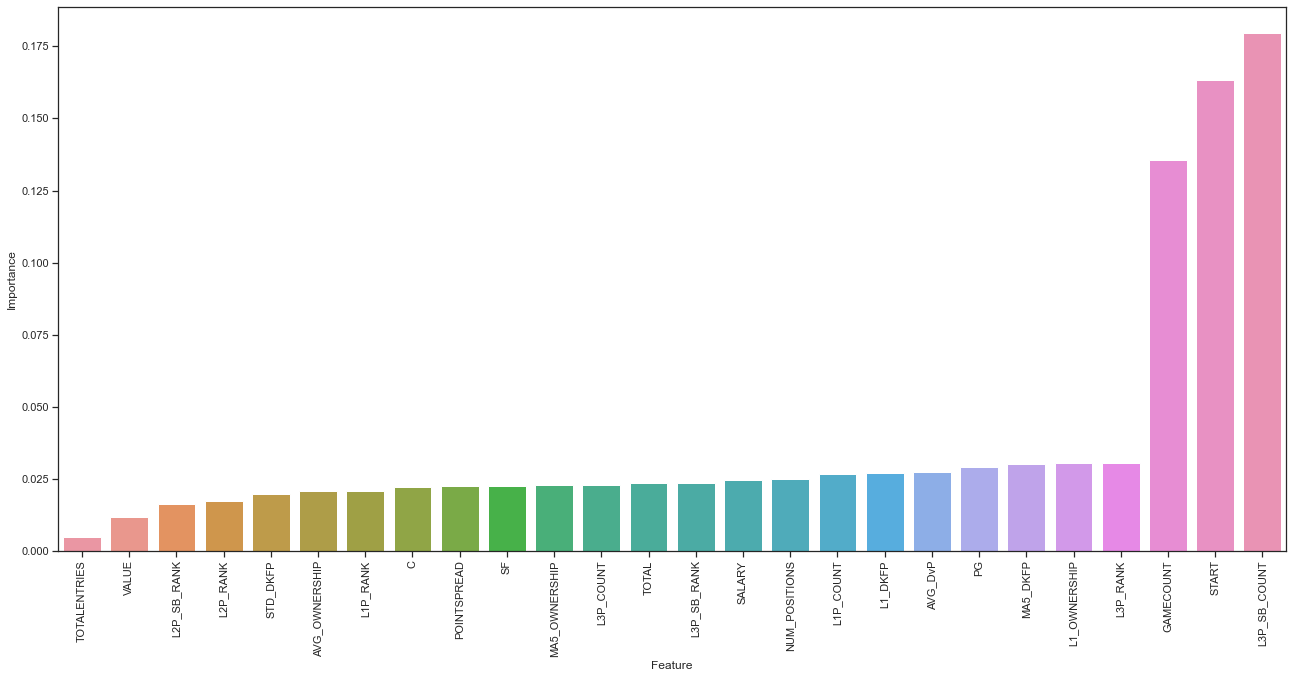

In [42]:
feature_importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'Importance': feature_importances, 'Feature': selected_features})
feature_importance_df = feature_importance_df.sort_values(by='Importance')
ax = sns.barplot(x="Feature", y="Importance", data=feature_importance_df)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

I will calculate a few metrics to evaluate the model's predictive power.

In [46]:
y_avg = feature_matrix.loc[X_test.index, 'AVG_OWNERSHIP']

# Kpi
print("R2 (explained variance):")
print("Model:", round(metrics.r2_score(y_test, y_hat), 3))
print("Baseline:", round(metrics.r2_score(y_test, y_avg), 3))

print("\nMean Absolute Error (Σ|y-pred|/n):")
print("Model:", round(metrics.mean_absolute_error(y_test, y_hat), 6))
print("Baseline:", round(metrics.mean_absolute_error(y_test, y_avg), 6))

print("\nRoot Mean Squared Error (sqrt(Σ(y-pred)^2/n)):")
print("Model:", round(np.sqrt(metrics.mean_squared_error(y_test, y_hat)), 6))
print("Baseline:", round(np.sqrt(metrics.mean_squared_error(y_test, y_avg)), 6))

R2 (explained variance):
Model: 0.953
Baseline: 0.126

Mean Absolute Error (Σ|y-pred|/n):
Model: 0.014035
Baseline: 0.07107

Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)):
Model: 0.02853
Baseline: 0.122914


Residual analysis:

No handles with labels found to put in legend.
No handles with labels found to put in legend.


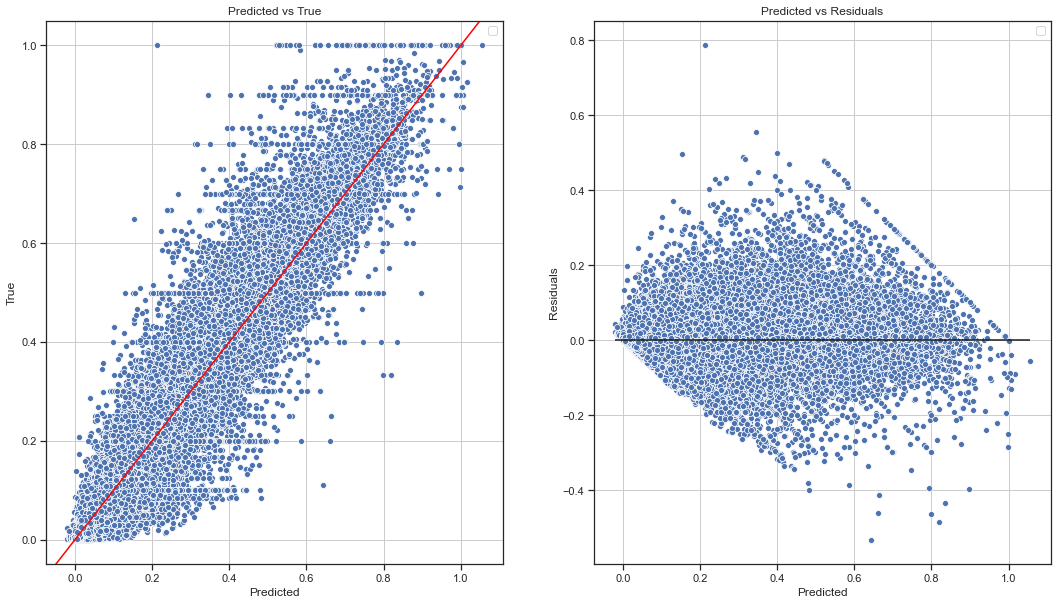

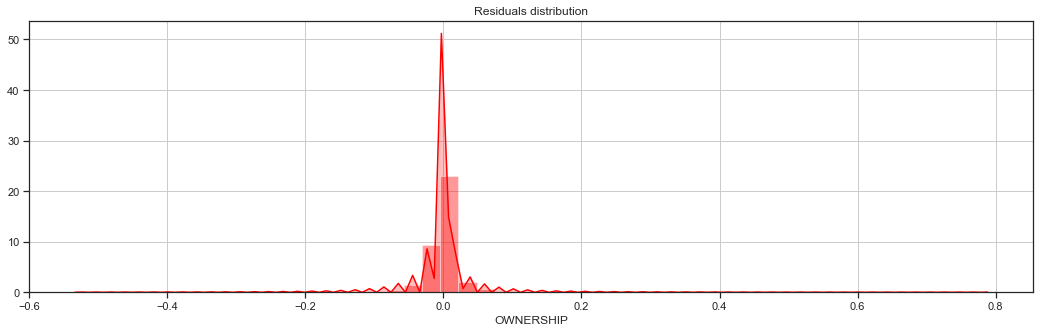

In [48]:
residuals = y_test - y_hat

# plot predicted vs true
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 10))
sns.scatterplot(y_hat, y_test, ax=ax[0])
abline_plot(intercept=0, slope=1, color="red", ax=ax[0])
ax[0].grid(True)
ax[0].set(xlabel="Predicted", ylabel="True", title="Predicted vs True")
ax[0].legend()
    
# plot predicted vs residuals
sns.scatterplot(y_hat, residuals, ax=ax[1])
ax[1].grid(True)
ax[1].set(xlabel="Predicted", ylabel="Residuals", title="Predicted vs Residuals")
ax[1].hlines(y=0, xmin=np.min(y_hat), xmax=np.max(y_hat))
ax[1].legend()
plt.show()

fig, ax = plt.subplots(figsize=(18, 5))
sns.distplot(residuals, color="red", hist=True, kde=True, kde_kws={"shade":True}, ax=ax)
ax.grid(True)
ax.set(title="Residuals distribution")
plt.show()

In [49]:
stat, p = shapiro(residuals)
print(stat, p)

0.6932845711708069 0.0


Residuals are normally distributed and not heteroskedastic.

In [50]:
pd.set_option('display.max_columns', 200)
pd.set_option('display.min_rows', 100)
pd.set_option('display.max_rows', 100)
display(feature_matrix)

,DATE,NAME,AVG_DKFP,VALUE,L1_DKFP,MA5_DKFP,SALARY,SALARY_CHANGE,STD_DKFP,START,NUM_POSITIONS,AVG_OWNERSHIP,L1_OWNERSHIP,MA5_OWNERSHIP,AVG_DvP,TOTAL,POINTSPREAD,TOTALENTRIES,MAXENTRIES,ENTRYFEE,TOPPRIZE,GAMECOUNT,L1P_COUNT,L1P_RANK,L1P_SB_COUNT,L1P_SB_RANK,L2P_COUNT,L2P_RANK,L2P_SB_COUNT,L2P_SB_RANK,L3P_COUNT,L3P_RANK,L3P_SB_COUNT,L3P_SB_RANK,COUNT_GP,SF,SG,PG,PF,C,OWNERSHIP
9482,2017-10-20,Alec Peters,9.250000,0.003083,9.25,9.25,3000.0,0.0,2.312500,0.0,2.0,0.000100,0.000100,0.000100,0.000000,222.0,-3.0,38146,20.0,4.0,20000.0,2,13.0,9.5,7.5,3.5,26.0,18.0,15.0,6.0,64.0,44.0,31.0,17.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0015
9486,2017-10-20,Alex Caruso,5.750000,0.001917,5.75,5.75,3000.0,0.0,1.437500,0.0,2.0,0.000718,0.000718,0.000718,0.000000,222.0,3.0,863,25.0,27.0,2000.0,2,13.5,14.5,11.0,8.0,27.0,28.0,22.0,15.0,64.0,65.0,31.0,32.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0012
9487,2017-10-20,Alex Caruso,5.750000,0.001917,5.75,5.75,3000.0,0.0,1.437500,0.0,2.0,0.000718,0.000718,0.000718,0.000000,222.0,3.0,38146,20.0,4.0,20000.0,2,13.5,14.5,11.0,8.0,27.0,28.0,22.0,15.0,64.0,65.0,31.0,32.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0012
9501,2017-10-20,Andrew Bogut,8.500000,0.002833,8.50,8.50,3000.0,0.0,2.125000,0.0,1.0,0.004947,0.004947,0.004947,0.000000,222.0,3.0,863,25.0,27.0,2000.0,2,11.0,8.0,7.0,3.0,11.0,8.0,7.0,3.0,64.0,54.0,31.0,21.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0012
9502,2017-10-20,Andrew Bogut,8.500000,0.002833,8.50,8.50,3000.0,0.0,2.125000,0.0,1.0,0.004947,0.004947,0.004947,0.000000,222.0,3.0,38146,20.0,4.0,20000.0,2,11.0,8.0,7.0,3.0,11.0,8.0,7.0,3.0,64.0,54.0,31.0,21.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0050
9504,2017-10-20,Anthony Davis,57.000000,0.005377,57.00,57.00,10600.0,100.0,14.250000,1.0,2.0,0.034484,0.034484,0.034484,0.000000,222.5,6.5,10,1.0,1060.0,5000.0,2,12.0,4.0,2.0,2.0,18.5,5.5,2.0,2.0,64.0,16.0,4.0,3.0,1.0,0.0,0.0,0.0,1.0,1.0,0.2000
9505,2017-10-20,Anthony Davis,57.000000,0.005377,57.00,57.00,10600.0,100.0,14.250000,1.0,2.0,0.034484,0.034484,0.034484,0.000000,222.5,6.5,44,1.0,150.0,1000.0,2,12.0,4.0,2.0,2.0,18.5,5.5,2.0,2.0,64.0,16.0,4.0,3.0,1.0,0.0,0.0,0.0,1.0,1.0,0.3864
9506,2017-10-20,Anthony Davis,57.000000,0.005377,57.00,57.00,10600.0,100.0,14.250000,1.0,2.0,0.034484,0.034484,0.034484,0.000000,222.5,6.5,863,25.0,27.0,2000.0,2,12.0,4.0,2.0,2.0,18.5,5.5,2.0,2.0,64.0,16.0,4.0,3.0,1.0,0.0,0.0,0.0,1.0,1.0,0.3835
9507,2017-10-20,Anthony Davis,57.000000,0.005377,57.00,57.00,10600.0,100.0,14.250000,1.0,2.0,0.034484,0.034484,0.034484,0.000000,222.5,6.5,38146,20.0,4.0,20000.0,2,12.0,4.0,2.0,2.0,18.5,5.5,2.0,2.0,64.0,16.0,4.0,3.0,1.0,0.0,0.0,0.0,1.0,1.0,0.4382
9508,2017-10-20,Anthony Davis,57.000000,0.005377,57.00,57.00,10600.0,100.0,14.250000,1.0,2.0,0.034484,0.034484,0.034484,0.000000,222.5,6.5,67,2.0,300.0,5000.0,2,12.0,4.0,2.0,2.0,18.5,5.5,2.0,2.0,64.0,16.0,4.0,3.0,1.0,0.0,0.0,0.0,1.0,1.0,0.4328


In [57]:
display(ownership.loc[(ownership['DATE'] == '2017-10-20') & (ownership['NAME'] == 'Anthony Davis')])

,SLATEID,PLAYERNAME,CONTESTNAME,OWNERSHIP,NAME,DATE,GAMEID,SEASON
432088,5ae4cbe2c074cf3dff32fa1b,Anthony Davis,NBA $10K All-Star [Single Entry] (Night),0.2000,Anthony Davis,2017-10-20,0021700025,2017-18
432089,5ae4cbe2c074cf3dff32fa1b,Anthony Davis,NBA $6K Posterizer [Single Entry] (Night),0.3864,Anthony Davis,2017-10-20,0021700025,2017-18
432090,5ae4cbe2c074cf3dff32fa1b,Anthony Davis,NBA $20K Crossover (Night),0.3835,Anthony Davis,2017-10-20,0021700025,2017-18
432091,5ae4cbe2c074cf3dff32fa1b,Anthony Davis,NBA $150K Late Night Snack [$20K to 1st] (Night),0.4382,Anthony Davis,2017-10-20,0021700025,2017-18
432092,5ae4cbe2c074cf3dff32fa1b,Anthony Davis,NBA $18.5K 3 Ball (Night),0.4328,Anthony Davis,2017-10-20,0021700025,2017-18
544612,5ae4d5895689223dfa12e192,Anthony Davis,NBA $10K All-Star [Single Entry],0.1000,Anthony Davis,2017-10-20,0021700025,2017-18
544613,5ae4d5895689223dfa12e192,Anthony Davis,NBA $100K Thunderdome [Single Entry],0.1053,Anthony Davis,2017-10-20,0021700025,2017-18
544614,5ae4d5895689223dfa12e192,Anthony Davis,NBA $50K Posterizer [3 Entry Max],0.1000,Anthony Davis,2017-10-20,0021700025,2017-18
544615,5ae4d5895689223dfa12e192,Anthony Davis,NBA $5K Windmill [3 Entry Max],0.1416,Anthony Davis,2017-10-20,0021700025,2017-18
544616,5ae4d5895689223dfa12e192,Anthony Davis,NBA $40K Buzzer Beater [3 Entry Max],0.1293,Anthony Davis,2017-10-20,0021700025,2017-18


In [55]:
display(contests.loc[(contests['SLATEID'] == '5ae4cbe2c074cf3dff32fa1b')])

,SITE,DATE,SLATEID,SLATETYPE,GAMECOUNT,TEAMS,CONTESTID,CONTESTNAME,PRIZEPOOL,ENTRYFEE,TOPPRIZE,MAXENTRIES,TOTALENTRIES,CASHLINE,TOPSCORE,MAXROI
25677,DRAFTKINGS,2017-10-20,5ae4cbe2c074cf3dff32fa1b,Classic,2,GSW_NOP_PHO_LAL,5ae630b49b41d020926231af,NBA $10K All-Star [Single Entry] (Night),10000.0,1060.0,5000.0,1.0,10,295.25,296.25,4.716981
25678,DRAFTKINGS,2017-10-20,5ae4cbe2c074cf3dff32fa1b,Classic,2,GSW_NOP_PHO_LAL,5ae6342c940f5a2090865a79,NBA $6K Posterizer [Single Entry] (Night),6000.0,150.0,1000.0,1.0,44,299.75,330.00,6.666667
25679,DRAFTKINGS,2017-10-20,5ae4cbe2c074cf3dff32fa1b,Classic,2,GSW_NOP_PHO_LAL,5ae4cbe2c074cf3dff32fa60,NBA $20K Crossover (Night),20000.0,27.0,2000.0,25.0,863,301.50,340.50,74.074074
25680,DRAFTKINGS,2017-10-20,5ae4cbe2c074cf3dff32fa1b,Classic,2,GSW_NOP_PHO_LAL,5ae4cd380f94ac3e0182664d,NBA $150K Late Night Snack [$20K to 1st] (Night),150000.0,4.0,20000.0,20.0,38146,298.50,364.75,5000.000000
25681,DRAFTKINGS,2017-10-20,5ae4cbe2c074cf3dff32fa1b,Classic,2,GSW_NOP_PHO_LAL,5ae4cdfe0f94ac3e0184679c,NBA $18.5K 3 Ball (Night),18500.0,300.0,5000.0,2.0,67,299.75,337.50,16.666667
